In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0ddbf3a48a65413bcbe896ac116540f91d2f99b26ea5ab6a9359e873baf9b91e
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 37.6 MB/s eta 0:00:00


In [ ]:
!pip install pandas_datareader

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.0 MB/s eta 0:00:00


In [ ]:
!pip install yfinance  statsmodels  arch scikit-learn tensorflow keras-tuner google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 51.7 MB/s eta 0:00:00


# Import Libraries

In [ ]:

# Standard library

import os
import re
import math
import time
import warnings
from typing import Dict, Iterable, List, Tuple



# Data & plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sns  # ← Optional: only if you actually use it

# Time series IO/tools
import yfinance as yf
from dateutil.parser import parse

# ML / metrics / preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Deep learning (use ONE style: tf.keras)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, models, regularizers
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Hyperparameter tuning
import keras_tuner as kt
import optuna

# Stats / classical TS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Technical indicators (ta)
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD, SMAIndicator, PSARIndicator
from ta.volatility import AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from scipy.stats import norm

# Google (only if you actually use Gemini/Colab)
# Comment these out if not needed.
import google.generativeai as genai
from google.api_core import exceptions
from google.colab import userdata  # Colab-only

#  Global settings

warnings.filterwarnings("ignore")
os.environ.pop("HTTP_PROXY", None)
os.environ.pop("HTTPS_PROXY", None)
plt.rcParams["figure.figsize"] = (10, 4)


tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported and proxy settings cleared.")


Libraries imported and proxy settings cleared.


# Load datasets

In [ ]:
#  Daily OHLCV (full history)
eth_daily = yf.download(
    tickers="ETH-USD",     # Yahoo Finance ticker for Ethereum in USD
    interval="1d",
    start="2015-08-01",    # set the start date you need
    auto_adjust=False,
    progress=False,
)
eth_daily.index.name = "Date"

# Optional: save to CSV
eth_daily.to_csv("eth_usd_daily.csv")

In [ ]:
 # df is your DataFrame
df = eth_daily.copy()
df

Price         Adj Close        Close         High          Low         Open  \
Ticker          ETH-USD      ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Date                                                                          
2017-11-09   320.884003   320.884003   329.451996   307.056000   308.644989   
2017-11-10   299.252991   299.252991   324.717987   294.541992   320.670990   
2017-11-11   314.681000   314.681000   319.453003   298.191986   298.585999   
2017-11-12   307.907990   307.907990   319.153015   298.513000   314.690002   
2017-11-13   316.716003   316.716003   328.415009   307.024994   307.024994   
...                 ...          ...          ...          ...          ...   
2025-09-03  4450.389160  4450.389160  4489.198730  4286.206055  4324.696289   
2025-09-04  4298.744141  4298.744141  4483.451172  4268.588867  4450.215820   
2025-09-05  4306.988770  4306.988770  4484.361328  4258.049805  4298.836914   
2025-09-06  4274.242188  4274.242188  4327.439941  4244.754883  4306.973145   
2025-09-08  4308.942871  4308.942871  4314.838867  4273.783691  4273.783691   

Price            Volume  
Ticker          ETH-USD  
Date                     
2017-11-09    893249984  
2017-11-10    885985984  
2017-11-11    842300992  
2017-11-12   1613479936  
2017-11-13   1041889984  
...                 ...  
2025-09-03  35260873497  
2025-09-04  34919798552  
2025-09-05  44163736676  
2025-09-06  18108246446  
2025-09-08  17096317952  

[2860 rows x 6 columns]

In [ ]:
# Reset the index so 'Date' becomes a column
df = df.reset_index()

# Flatten the MultiIndex columns
df.columns = df.columns.get_level_values(-0)

# Rename columns with prefix "gold"
df = df.rename(columns={
    "Date": "Date",
    "Close": "Close",
    "Open": "Open",
    "High": "High",
    "Low": "Low",
    "Volume": "Volume"
})

df.columns.name = None
df

Date    Adj Close        Close         High          Low  \
0    2017-11-09   320.884003   320.884003   329.451996   307.056000   
1    2017-11-10   299.252991   299.252991   324.717987   294.541992   
2    2017-11-11   314.681000   314.681000   319.453003   298.191986   
3    2017-11-12   307.907990   307.907990   319.153015   298.513000   
4    2017-11-13   316.716003   316.716003   328.415009   307.024994   
...         ...          ...          ...          ...          ...   
2855 2025-09-03  4450.389160  4450.389160  4489.198730  4286.206055   
2856 2025-09-04  4298.744141  4298.744141  4483.451172  4268.588867   
2857 2025-09-05  4306.988770  4306.988770  4484.361328  4258.049805   
2858 2025-09-06  4274.242188  4274.242188  4327.439941  4244.754883   
2859 2025-09-08  4308.942871  4308.942871  4314.838867  4273.783691   

             Open       Volume  
0      308.644989    893249984  
1      320.670990    885985984  
2      298.585999    842300992  
3      314.690002   1613479936  
4      307.024994   1041889984  
...           ...          ...  
2855  4324.696289  35260873497  
2856  4450.215820  34919798552  
2857  4298.836914  44163736676  
2858  4306.973145  18108246446  
2859  4273.783691  17096317952  

[2860 rows x 7 columns]

In [ ]:
ETH = pd.read_csv("ETH-USD.csv", usecols=[ "Date", "Open","High","Low","Close", "Adj Close"	,"Volume"])
ETH["Date"] = pd.to_datetime(ETH["Date"], errors="coerce")

In [ ]:
import pandas as pd

# --- 1) Standardize both DataFrames to a common schema ---
def standardize_eth_table(x: pd.DataFrame) -> pd.DataFrame:
    out = x.copy()

    # Drop stray index column if present
    if 'index' in out.columns:
        out = out.drop(columns=['index'])

    # Unify column names
    rename_map = {
        'ETH_open': 'Open',
        'ETH_high': 'High',
        'ETH_low':  'Low',
        'ETH_close':'Close',
        'ETH_volume':'Volume',
        'Adj_Close':'Adj Close',   # just in case underscore version appears
    }
    out = out.rename(columns=rename_map)

    # Ensure required columns exist
    cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for c in cols:
        if c not in out.columns:
            out[c] = pd.NA

    # Clean types
    out['Date'] = pd.to_datetime(out['Date'], errors='coerce')
    for c in ['Open','High','Low','Close','Adj Close','Volume']:
        out[c] = pd.to_numeric(out[c], errors='coerce')

    # De-duplicate and sort
    out = (out[cols]
           .dropna(subset=['Date'])
           .drop_duplicates(subset=['Date'])
           .sort_values('Date')
           .reset_index(drop=True))
    return out

eth_2015_2021 = standardize_eth_table(ETH)   # yfinance slice ending in 2021
eth_2017_2025 = standardize_eth_table(df)    # your table starting 2017

# --- 2) Full coverage 2015–2025:
# Prefer df (2017–2025) where both have data; fill gaps with yfinance rows (2015–2017 + any holes).
full_eth = (
    eth_2017_2025.set_index('Date')
                 .combine_first(eth_2015_2021.set_index('Date'))
                 .reset_index()
                 .sort_values('Date')
                 .reset_index(drop=True)
)

# --- 3) Optional: if Adj Close is missing but Close exists, copy it
mask_adj_missing = full_eth['Adj Close'].isna() & full_eth['Close'].notna()
full_eth.loc[mask_adj_missing, 'Adj Close'] = full_eth.loc[mask_adj_missing, 'Close']

# --- 4) Sanity checks
print("Date coverage:", full_eth['Date'].min().date(), "→", full_eth['Date'].max().date())
print("Rows:", len(full_eth))
print("Any OHLC missing?", full_eth[['Open','High','Low','Close']].isna().any().any())
full_eth.head(), full_eth.tail()


Date coverage: 2015-08-07 → 2025-09-08
Rows: 3685
Any OHLC missing? False


(        Date      Open      High       Low     Close  Adj Close     Volume
 0 2015-08-07  2.831620  3.536610  2.521120  2.772120   2.772120   164329.0
 1 2015-08-08  2.793760  2.798810  0.714725  0.753325   0.753325   674188.0
 2 2015-08-09  0.706136  0.879810  0.629191  0.701897   0.701897   532170.0
 3 2015-08-10  0.713989  0.729854  0.636546  0.708448   0.708448   405283.0
 4 2015-08-11  0.708087  1.131410  0.663235  1.067860   1.067860  1463100.0,
            Date         Open         High          Low        Close  \
 3680 2025-09-03  4324.696289  4489.198730  4286.206055  4450.389160   
 3681 2025-09-04  4450.215820  4483.451172  4268.588867  4298.744141   
 3682 2025-09-05  4298.836914  4484.361328  4258.049805  4306.988770   
 3683 2025-09-06  4306.973145  4327.439941  4244.754883  4274.242188   
 3684 2025-09-08  4273.783691  4314.838867  4273.783691  4308.942871   
 
         Adj Close        Volume  
 3680  4450.389160  3.526087e+10  
 3681  4298.744141  3.491980e+10  
 368

In [ ]:
df = full_eth.copy()
df

Date         Open         High          Low        Close  \
0    2015-08-07     2.831620     3.536610     2.521120     2.772120   
1    2015-08-08     2.793760     2.798810     0.714725     0.753325   
2    2015-08-09     0.706136     0.879810     0.629191     0.701897   
3    2015-08-10     0.713989     0.729854     0.636546     0.708448   
4    2015-08-11     0.708087     1.131410     0.663235     1.067860   
...         ...          ...          ...          ...          ...   
3680 2025-09-03  4324.696289  4489.198730  4286.206055  4450.389160   
3681 2025-09-04  4450.215820  4483.451172  4268.588867  4298.744141   
3682 2025-09-05  4298.836914  4484.361328  4258.049805  4306.988770   
3683 2025-09-06  4306.973145  4327.439941  4244.754883  4274.242188   
3684 2025-09-08  4273.783691  4314.838867  4273.783691  4308.942871   

        Adj Close        Volume  
0        2.772120  1.643290e+05  
1        0.753325  6.741880e+05  
2        0.701897  5.321700e+05  
3        0.708448  4.052830e+05  
4        1.067860  1.463100e+06  
...           ...           ...  
3680  4450.389160  3.526087e+10  
3681  4298.744141  3.491980e+10  
3682  4306.988770  4.416374e+10  
3683  4274.242188  1.810825e+10  
3684  4308.942871  1.709632e+10  

[3685 rows x 7 columns]

In [ ]:

# If the Date is currently the index, bring it back as a column first
if "Date" not in df.columns and isinstance(df.index, pd.DatetimeIndex):
    df = df.reset_index().rename(columns={"index": "Date"})

# Ensure Date column exists and is datetime
if "Date" not in df.columns:
    raise ValueError("No 'Date' column found. Either reset the index or rename your date column to 'Date'.")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Now your original line works:
df_2015_2024 = df[df["Date"].between(pd.Timestamp("2015-04-01"),
                                     pd.Timestamp("2024-04-01"),
                                     inclusive="both")].reset_index(drop=True)
df_2015_2024

Date         Open         High          Low        Close  \
0    2015-08-07     2.831620     3.536610     2.521120     2.772120   
1    2015-08-08     2.793760     2.798810     0.714725     0.753325   
2    2015-08-09     0.706136     0.879810     0.629191     0.701897   
3    2015-08-10     0.713989     0.729854     0.636546     0.708448   
4    2015-08-11     0.708087     1.131410     0.663235     1.067860   
...         ...          ...          ...          ...          ...   
3156 2024-03-28  3500.216064  3609.705322  3465.332275  3561.293945   
3157 2024-03-29  3561.011719  3583.701416  3475.725586  3511.806152   
3158 2024-03-30  3511.827637  3566.084473  3489.902100  3507.944336   
3159 2024-03-31  3507.951660  3655.218994  3507.242676  3647.856445   
3160 2024-04-01  3647.819580  3648.129150  3418.695312  3505.030029   

        Adj Close        Volume  
0        2.772120  1.643290e+05  
1        0.753325  6.741880e+05  
2        0.701897  5.321700e+05  
3        0.708448  4.052830e+05  
4        1.067860  1.463100e+06  
...           ...           ...  
3156  3561.293945  1.641967e+10  
3157  3511.806152  1.271270e+10  
3158  3507.944336  9.389067e+09  
3159  3647.856445  1.049988e+10  
3160  3505.030029  1.600210e+10  

[3161 rows x 7 columns]

In [ ]:
# ensure Date is datetime
df_2015_2024["Date"] = pd.to_datetime(df_2015_2024["Date"], errors="coerce")

# make Date the index (appears on the left) and sort by it
df_2015_2024 = df_2015_2024.set_index("Date").sort_index()

df_2015_2024

Open         High          Low        Close    Adj Close  \
Date                                                                          
2015-08-07     2.831620     3.536610     2.521120     2.772120     2.772120   
2015-08-08     2.793760     2.798810     0.714725     0.753325     0.753325   
2015-08-09     0.706136     0.879810     0.629191     0.701897     0.701897   
2015-08-10     0.713989     0.729854     0.636546     0.708448     0.708448   
2015-08-11     0.708087     1.131410     0.663235     1.067860     1.067860   
...                 ...          ...          ...          ...          ...   
2024-03-28  3500.216064  3609.705322  3465.332275  3561.293945  3561.293945   
2024-03-29  3561.011719  3583.701416  3475.725586  3511.806152  3511.806152   
2024-03-30  3511.827637  3566.084473  3489.902100  3507.944336  3507.944336   
2024-03-31  3507.951660  3655.218994  3507.242676  3647.856445  3647.856445   
2024-04-01  3647.819580  3648.129150  3418.695312  3505.030029  3505.030029   

                  Volume  
Date                      
2015-08-07  1.643290e+05  
2015-08-08  6.741880e+05  
2015-08-09  5.321700e+05  
2015-08-10  4.052830e+05  
2015-08-11  1.463100e+06  
...                  ...  
2024-03-28  1.641967e+10  
2024-03-29  1.271270e+10  
2024-03-30  9.389067e+09  
2024-03-31  1.049988e+10  
2024-04-01  1.600210e+10  

[3161 rows x 6 columns]

In [ ]:
ETH_df = df_2015_2024.copy()

In [ ]:
gold = yf.download("GC=F", start="2015-04-01", end="2024-04-02")
gold

[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open  Volume
Ticker             GC=F         GC=F         GC=F         GC=F    GC=F
Date                                                                  
2015-04-01  1208.099976  1208.199951  1181.000000  1182.900024    1632
2015-04-02  1200.900024  1205.699951  1194.800049  1204.000000    1684
2015-04-06  1218.599976  1224.199951  1209.900024  1209.900024     343
2015-04-07  1210.599976  1214.800049  1208.199951  1214.800049     406
2015-04-08  1203.099976  1211.400024  1197.599976  1208.900024     236
...                 ...          ...          ...          ...     ...
2024-03-25  2174.800049  2179.399902  2166.199951  2166.199951      79
2024-03-26  2175.600098  2182.699951  2175.600098  2182.699951  202373
2024-03-27  2190.600098  2196.199951  2172.100098  2179.399902   31200
2024-03-28  2217.399902  2234.100098  2187.100098  2193.600098    2040
2024-04-01  2236.500000  2264.199951  2230.000000  2235.699951     400

[2262 rows x 5 columns]

In [ ]:
# Reset the index so 'Date' becomes a column
gold = gold.reset_index()

# Flatten the MultiIndex columns
gold.columns = gold.columns.get_level_values(-0)

# Rename columns with prefix "gold"
gold = gold.rename(columns={
    "Date": "Date",
    "Close": "gold_close",
    "Open": "gold_open",
    "High": "gold_high",
    "Low": "gold_low",
    "Volume": "gold_volume"
})

gold.columns.name = None
gold

Date   gold_close    gold_high     gold_low    gold_open  \
0    2015-04-01  1208.099976  1208.199951  1181.000000  1182.900024   
1    2015-04-02  1200.900024  1205.699951  1194.800049  1204.000000   
2    2015-04-06  1218.599976  1224.199951  1209.900024  1209.900024   
3    2015-04-07  1210.599976  1214.800049  1208.199951  1214.800049   
4    2015-04-08  1203.099976  1211.400024  1197.599976  1208.900024   
...         ...          ...          ...          ...          ...   
2257 2024-03-25  2174.800049  2179.399902  2166.199951  2166.199951   
2258 2024-03-26  2175.600098  2182.699951  2175.600098  2182.699951   
2259 2024-03-27  2190.600098  2196.199951  2172.100098  2179.399902   
2260 2024-03-28  2217.399902  2234.100098  2187.100098  2193.600098   
2261 2024-04-01  2236.500000  2264.199951  2230.000000  2235.699951   

      gold_volume  
0            1632  
1            1684  
2             343  
3             406  
4             236  
...           ...  
2257           79  
2258       202373  
2259        31200  
2260         2040  
2261          400  

[2262 rows x 6 columns]

In [ ]:
# Load Excel file for GPRD data
gprd_df = pd.read_excel("data_gpr_daily_recent.xls", dtype={'DAY': str})

# Convert 'DAY' to datetime
gprd_df['Date'] = pd.to_datetime(gprd_df['DAY'], format='%Y%m%d')

# Keep only relevant columns: 'Date' and 'GPRD' (or GPRD_MA if preferred)
gprd_df = gprd_df[['Date', 'GPRD']]

# Filter only 2015 to 2024
gprd_df = gprd_df[(gprd_df['Date'] >= '2015-04-01') & (gprd_df['Date'] <= '2024-04-01')]

gprd_df

Date        GPRD
11047 2015-04-01  138.928131
11048 2015-04-02  113.846565
11049 2015-04-03  150.144714
11050 2015-04-04  165.628387
11051 2015-04-05  116.457458
...          ...         ...
14331 2024-03-28   99.626099
14332 2024-03-29  126.193062
14333 2024-03-30  161.588669
14334 2024-03-31  119.953705
14335 2024-04-01  123.224617

[3289 rows x 2 columns]

In [ ]:
# Load the CSV file (no header issues)
EPU_df = pd.read_csv("All_Daily_Policy_Data.csv", header=0, names=["day", "month", "year", "EPU"])

# Create a new 'Date' column from day, month, year
EPU_df['Date'] = pd.to_datetime(EPU_df[['year', 'month', 'day']])

# Keep only relevant columns
EPU_df = EPU_df[['Date', 'EPU']]


# Filter the data from 2015-04-01 to 2024-04-01
EPU_df = EPU_df[(EPU_df['Date'] >= "2015-04-01") & (EPU_df['Date'] <= "2024-04-01")]

# Save it if needed
EPU_df.to_csv("EPU_2015_2024.csv", index=False)

# Preview
EPU_df

Date     EPU
11047 2015-04-01   85.27
11048 2015-04-02   27.58
11049 2015-04-03   69.18
11050 2015-04-04  123.38
11051 2015-04-05  106.94
...          ...     ...
14331 2024-03-28   59.31
14332 2024-03-29   90.04
14333 2024-03-30   49.51
14334 2024-03-31   89.56
14335 2024-04-01  113.74

[3289 rows x 2 columns]

In [ ]:

# Si tu as déjà un DataFrame 'gold' en mémoire, on s'assure du nommage :
try:
    gold
except NameError:
    # Si aucune source ci-dessus, on fabrique un proxy vide (résoudra une erreur explicite)
    gold = pd.DataFrame(columns=["Date","gold_close"])

# Harmonise la casse si besoin (par ex. colonnes en minuscules)
gold.columns = [c.lower() for c in gold.columns]
if "date" in gold.columns and "gold_close" in gold.columns:
    gold = gold.rename(columns={"date":"Date"})
elif "Date" not in gold.columns and len(gold) > 0:
    raise ValueError("Le DataFrame 'gold' doit contenir les colonnes 'Date' et 'gold_close'.")

if len(gold) > 0:
    gold["Date"] = pd.to_datetime(gold["Date"], errors="coerce")
    gold = (gold.dropna(subset=["Date"])
                .set_index("Date")[["gold_close"]]
                .sort_index()
                .asfreq("D")
                .ffill(limit=7))

# ---- EPU
EPU_df = pd.read_csv("All_Daily_Policy_Data.csv", header=0,
                     names=["day","month","year","EPU"])
EPU_df["Date"] = pd.to_datetime(EPU_df[["year","month","day"]])
EPU = (EPU_df.set_index("Date")[["EPU"]]
                .sort_index()
                .asfreq("D")
                .ffill(limit=7))

# ---- GPRD
gprd_df = pd.read_excel("data_gpr_daily_recent.xls", dtype={"DAY": str})
gprd_df["Date"] = pd.to_datetime(gprd_df["DAY"], format="%Y%m%d", errors="coerce")
GPRD = (gprd_df.dropna(subset=["Date"])
               .set_index("Date")[["GPRD"]]
               .sort_index()
               .asfreq("D")
               .ffill(limit=7))

# Synchronise sur la grille BTC, puis décalage t-1 (pas de fuite)
exo = pd.concat([gold, EPU, GPRD], axis=1).reindex(ETH_df.index)
#exo = exo.shift(1)



In [ ]:
# ================================
# 2) Techniques (MA, EMA, OBV, MACD, Signal, PSAR) sans fuite
# ================================

def psar_series(high: pd.Series, low: pd.Series,
                step: float = 0.02, max_step: float = 0.20) -> pd.Series:
    """PSAR simple (paramètres de l'annexe : step=0.02, max=0.20)."""
    idx = high.index
    h = high.to_numpy(dtype=float)
    l = low.to_numpy(dtype=float)

    psar = np.zeros_like(h, dtype=float)
    bull = True
    af = step
    ep = h[0]
    psar[0] = l[0]

    for i in range(1, len(h)):
        prev = psar[i-1]
        if bull:
            v = prev + af * (ep - prev)
            v = min(v, l[i-1], l[i-2] if i >= 2 else l[i-1])
            if h[i] > ep:
                ep = h[i]; af = min(af + step, max_step)
            if l[i] < v:
                bull = False; psar[i] = ep; ep = l[i]; af = step
            else:
                psar[i] = v
        else:
            v = prev + af * (ep - prev)
            v = max(v, h[i-1], h[i-2] if i >= 2 else h[i-1])
            if l[i] < ep:
                ep = l[i]; af = min(af + step, max_step)
            if h[i] > v:
                bull = True; psar[i] = ep; ep = h[i]; af = step
            else:
                psar[i] = v
    return pd.Series(psar, index=idx, name="PSAR")

ta = pd.DataFrame(index=ETH_df.index)
ta["Open"]   = ETH_df["Open"]
ta["High"]   = ETH_df["High"]
ta["Low"]    = ETH_df["Low"]
ta["Close"]  = ETH_df["Close"]
ta["Volume"] = ETH_df["Volume"]

# Pct change (journalier)
ta["Pct_change"] = ta["Close"].pct_change()

# MA / EMA (fenêtre 30, style annexe)
win = 30
ta["MA"]  = ta["Close"].rolling(win, min_periods=win).mean()
ta["EMA"] = ta["Close"].ewm(span=win, adjust=False, min_periods=win).mean()

# OBV
delta = ta["Close"].diff()
direction = (delta > 0).astype(int) - (delta < 0).astype(int)
ta["OBV"] = (direction * ta["Volume"]).fillna(0).cumsum()

# MACD(12,26) + signal(9)
ema12 = ta["Close"].ewm(span=12, adjust=False).mean()
ema26 = ta["Close"].ewm(span=26, adjust=False).mean()
ta["MACD"]  = ema12 - ema26
ta["Signal"] = ta["MACD"].ewm(span=9, adjust=False).mean()

# PSAR
ta["PSAR"] = psar_series(ta["High"], ta["Low"])

# Décalage t-1 de toutes les features (anti-fuite)
lag_cols = ["Pct_change","MA","EMA","OBV","MACD","Signal","PSAR"]
ta[lag_cols] = ta[lag_cols].shift(1)

# Joins + fenêtre d’étude + drop warm-ups
data = (ta.join(exo, how="left")
          .loc["2014-04-01":"2024-04-01"]
          .dropna(subset=["Open","High","Low","Close","Volume",
                          "Pct_change","MA","EMA","OBV","MACD","Signal","PSAR",
                          "gold_close","EPU","GPRD"]))

# Fenêtre de l’article
data = data.loc["2016-04-01":"2024-04-01"].copy()
print("Lignes (paper):", len(data))  # ~ 2923 attendu


Lignes (paper): 2923


In [ ]:
data

Open         High          Low        Close        Volume  \
Date                                                                           
2016-04-01    11.400600    11.850400    11.400600    11.663600  1.137310e+07   
2016-04-02    11.630600    11.688800    11.398800    11.598900  8.682620e+06   
2016-04-03    11.628300    11.706400    11.508700    11.618300  5.580550e+06   
2016-04-04    11.615800    11.615800    11.016300    11.157300  9.599070e+06   
2016-04-05    11.212500    11.212500    10.134700    10.438100  2.055730e+07   
...                 ...          ...          ...          ...           ...   
2024-03-28  3500.216064  3609.705322  3465.332275  3561.293945  1.641967e+10   
2024-03-29  3561.011719  3583.701416  3475.725586  3511.806152  1.271270e+10   
2024-03-30  3511.827637  3566.084473  3489.902100  3507.944336  9.389067e+09   
2024-03-31  3507.951660  3655.218994  3507.242676  3647.856445  1.049988e+10   
2024-04-01  3647.819580  3648.129150  3418.695312  3505.030029  1.600210e+10   

            Pct_change           MA          EMA           OBV       MACD  \
Date                                                                        
2016-04-01   -0.045964    11.292169    10.518888  1.354246e+08   0.609327   
2016-04-02    0.022809    11.398776    10.592741  1.467977e+08   0.585931   
2016-04-03   -0.005547    11.475601    10.657654  1.381151e+08   0.555762   
2016-04-04    0.001673    11.516011    10.719631  1.436956e+08   0.527339   
2016-04-05   -0.039679    11.521131    10.747868  1.340966e+08   0.462287   
...                ...          ...          ...           ...        ...   
2024-03-28   -0.024359  3607.003491  3465.537924  1.468676e+12  30.347719   
2024-03-29    0.017479  3617.562646  3471.715732  1.485095e+12  31.032765   
2024-03-30   -0.013896  3621.766056  3474.302211  1.472383e+12  27.268088   
2024-03-31   -0.001100  3627.300212  3476.472671  1.462994e+12  23.699742   
2024-04-01    0.039884  3634.393628  3487.529688  1.473493e+12  31.795027   

               Signal         PSAR   gold_close     EPU        GPRD  
Date                                                                 
2016-04-01   0.812985    12.427995  1222.199951   30.46  156.704910  
2016-04-02   0.767574    12.271856  1222.199951   61.05   88.503716  
2016-04-03   0.725212    12.121962  1222.199951  100.09  105.790588  
2016-04-04   0.685637    11.978065  1218.000000   38.89  113.142723  
2016-04-05   0.640967    11.839923  1228.400024   25.71   89.260803  
...               ...          ...          ...     ...         ...  
2024-03-28  70.096780  3095.891496  2217.399902   59.31   99.626099  
2024-03-29  62.283977  3119.207428  2217.399902   90.04  126.193062  
2024-03-30  55.280799  3141.590723  2217.399902   49.51  161.588669  
2024-03-31  48.964588  3163.078686  2217.399902   89.56  119.953705  
2024-04-01  45.530676  3183.707130  2236.500000  113.74  123.224617  

[2923 rows x 15 columns]

In [ ]:
print("Colonnes du DataFrame :")
print(data.columns.tolist())


Colonnes du DataFrame :
['Open', 'High', 'Low', 'Close', 'Volume', 'Pct_change', 'MA', 'EMA', 'OBV', 'MACD', 'Signal', 'PSAR', 'gold_close', 'EPU', 'GPRD']


In [ ]:
# Décalage d’un jour pour éviter le data leakage
for col in ['EPU', 'GPRD', 'gold_close']:
    data[col] = data[col].shift(1)

# Remplir les trous restants
data = data.ffill().bfill()


print("Nombre de NaN restants :", data.isna().sum().sum())


Nombre de NaN restants : 0


In [ ]:
data

Open         High          Low        Close        Volume  \
Date                                                                           
2016-04-01    11.400600    11.850400    11.400600    11.663600  1.137310e+07   
2016-04-02    11.630600    11.688800    11.398800    11.598900  8.682620e+06   
2016-04-03    11.628300    11.706400    11.508700    11.618300  5.580550e+06   
2016-04-04    11.615800    11.615800    11.016300    11.157300  9.599070e+06   
2016-04-05    11.212500    11.212500    10.134700    10.438100  2.055730e+07   
...                 ...          ...          ...          ...           ...   
2024-03-28  3500.216064  3609.705322  3465.332275  3561.293945  1.641967e+10   
2024-03-29  3561.011719  3583.701416  3475.725586  3511.806152  1.271270e+10   
2024-03-30  3511.827637  3566.084473  3489.902100  3507.944336  9.389067e+09   
2024-03-31  3507.951660  3655.218994  3507.242676  3647.856445  1.049988e+10   
2024-04-01  3647.819580  3648.129150  3418.695312  3505.030029  1.600210e+10   

            Pct_change           MA          EMA           OBV       MACD  \
Date                                                                        
2016-04-01   -0.045964    11.292169    10.518888  1.354246e+08   0.609327   
2016-04-02    0.022809    11.398776    10.592741  1.467977e+08   0.585931   
2016-04-03   -0.005547    11.475601    10.657654  1.381151e+08   0.555762   
2016-04-04    0.001673    11.516011    10.719631  1.436956e+08   0.527339   
2016-04-05   -0.039679    11.521131    10.747868  1.340966e+08   0.462287   
...                ...          ...          ...           ...        ...   
2024-03-28   -0.024359  3607.003491  3465.537924  1.468676e+12  30.347719   
2024-03-29    0.017479  3617.562646  3471.715732  1.485095e+12  31.032765   
2024-03-30   -0.013896  3621.766056  3474.302211  1.472383e+12  27.268088   
2024-03-31   -0.001100  3627.300212  3476.472671  1.462994e+12  23.699742   
2024-04-01    0.039884  3634.393628  3487.529688  1.473493e+12  31.795027   

               Signal         PSAR   gold_close     EPU        GPRD  
Date                                                                 
2016-04-01   0.812985    12.427995  1222.199951   30.46  156.704910  
2016-04-02   0.767574    12.271856  1222.199951   30.46  156.704910  
2016-04-03   0.725212    12.121962  1222.199951   61.05   88.503716  
2016-04-04   0.685637    11.978065  1222.199951  100.09  105.790588  
2016-04-05   0.640967    11.839923  1218.000000   38.89  113.142723  
...               ...          ...          ...     ...         ...  
2024-03-28  70.096780  3095.891496  2190.600098   97.90  126.741722  
2024-03-29  62.283977  3119.207428  2217.399902   59.31   99.626099  
2024-03-30  55.280799  3141.590723  2217.399902   90.04  126.193062  
2024-03-31  48.964588  3163.078686  2217.399902   49.51  161.588669  
2024-04-01  45.530676  3183.707130  2217.399902   89.56  119.953705  

[2923 rows x 15 columns]

In [ ]:
# This moves the index into a column and creates a new default index.
data.reset_index(inplace=True)

# You can now see the 'Date' column is back to being a regular column
print(data.head())

        Date     Open     High      Low    Close      Volume  Pct_change  \
0 2016-04-01  11.4006  11.8504  11.4006  11.6636  11373100.0   -0.045964   
1 2016-04-02  11.6306  11.6888  11.3988  11.5989   8682620.0    0.022809   
2 2016-04-03  11.6283  11.7064  11.5087  11.6183   5580550.0   -0.005547   
3 2016-04-04  11.6158  11.6158  11.0163  11.1573   9599070.0    0.001673   
4 2016-04-05  11.2125  11.2125  10.1347  10.4381  20557300.0   -0.039679   

          MA        EMA          OBV      MACD    Signal       PSAR  \
0  11.292169  10.518888  135424619.0  0.609327  0.812985  12.427995   
1  11.398776  10.592741  146797719.0  0.585931  0.767574  12.271856   
2  11.475601  10.657654  138115099.0  0.555762  0.725212  12.121962   
3  11.516011  10.719631  143695649.0  0.527339  0.685637  11.978065   
4  11.521131  10.747868  134096579.0  0.462287  0.640967  11.839923   

    gold_close     EPU        GPRD  
0  1222.199951   30.46  156.704910  
1  1222.199951   30.46  156.704910  
2  12

In [ ]:
data_eth = data.copy()

In [ ]:
data_eth

Open         High          Low        Close        Volume  \
Date                                                                           
2016-04-01    11.400600    11.850400    11.400600    11.663600  1.137310e+07   
2016-04-02    11.630600    11.688800    11.398800    11.598900  8.682620e+06   
2016-04-03    11.628300    11.706400    11.508700    11.618300  5.580550e+06   
2016-04-04    11.615800    11.615800    11.016300    11.157300  9.599070e+06   
2016-04-05    11.212500    11.212500    10.134700    10.438100  2.055730e+07   
...                 ...          ...          ...          ...           ...   
2024-03-28  3500.216064  3609.705322  3465.332275  3561.293945  1.641967e+10   
2024-03-29  3561.011719  3583.701416  3475.725586  3511.806152  1.271270e+10   
2024-03-30  3511.827637  3566.084473  3489.902100  3507.944336  9.389067e+09   
2024-03-31  3507.951660  3655.218994  3507.242676  3647.856445  1.049988e+10   
2024-04-01  3647.819580  3648.129150  3418.695312  3505.030029  1.600210e+10   

            Pct_change           MA          EMA           OBV       MACD  \
Date                                                                        
2016-04-01   -0.045964    11.292169    10.518888  1.354246e+08   0.609327   
2016-04-02    0.022809    11.398776    10.592741  1.467977e+08   0.585931   
2016-04-03   -0.005547    11.475601    10.657654  1.381151e+08   0.555762   
2016-04-04    0.001673    11.516011    10.719631  1.436956e+08   0.527339   
2016-04-05   -0.039679    11.521131    10.747868  1.340966e+08   0.462287   
...                ...          ...          ...           ...        ...   
2024-03-28   -0.024359  3607.003491  3465.537924  1.468676e+12  30.347719   
2024-03-29    0.017479  3617.562646  3471.715732  1.485095e+12  31.032765   
2024-03-30   -0.013896  3621.766056  3474.302211  1.472383e+12  27.268088   
2024-03-31   -0.001100  3627.300212  3476.472671  1.462994e+12  23.699742   
2024-04-01    0.039884  3634.393628  3487.529688  1.473493e+12  31.795027   

               Signal         PSAR   gold_close     EPU        GPRD  
Date                                                                 
2016-04-01   0.812985    12.427995  1222.199951   30.46  156.704910  
2016-04-02   0.767574    12.271856  1222.199951   30.46  156.704910  
2016-04-03   0.725212    12.121962  1222.199951   61.05   88.503716  
2016-04-04   0.685637    11.978065  1222.199951  100.09  105.790588  
2016-04-05   0.640967    11.839923  1218.000000   38.89  113.142723  
...               ...          ...          ...     ...         ...  
2024-03-28  70.096780  3095.891496  2190.600098   97.90  126.741722  
2024-03-29  62.283977  3119.207428  2217.399902   59.31   99.626099  
2024-03-30  55.280799  3141.590723  2217.399902   90.04  126.193062  
2024-03-31  48.964588  3163.078686  2217.399902   49.51  161.588669  
2024-04-01  45.530676  3183.707130  2217.399902   89.56  119.953705  

[2923 rows x 15 columns]

In [ ]:
# Save the DataFrame to a CSV file named 'my_dataset.csv'
data.to_csv('data_eth.csv', index=False)

In [ ]:
from google.colab import files

files.download('data_eth.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df=data.copy()

# LSTM

In [ ]:
def set_seeds(seed=42):
    import os, random
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.keras.utils.set_random_seed(seed)
    random.seed(seed); np.random.seed(seed)

def rmse(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    return float(np.sqrt(mean_squared_error(a, b)))

set_seeds(42)

def get_scalers(name="standard"):
    """Return (X_scaler, y_scaler). Use 'robust' for outlier-resilient scaling."""
    return (RobustScaler(), RobustScaler()) if name == "robust" else (StandardScaler(), StandardScaler())

def make_windows(X_2d: np.ndarray, y_1d: np.ndarray, lookback: int):
    """Build rolling windows of length `lookback` that end at each time t."""
    T, F = X_2d.shape
    if T <= lookback:
        return np.empty((0, lookback, F)), np.empty((0,))
    X = np.stack([X_2d[i - lookback:i, :] for i in range(lookback, T)], axis=0)
    y = y_1d[lookback - 1:]
    y = y[:len(X)]
    return X, y

def build_lstm(n_features, lookback, params):
    """Supports 1 or 2 stacked LSTM layers, plus dropout and selectable optimizer."""
    tf.keras.backend.clear_session()
    units  = params["units"]
    layers = params.get("layers", 1)
    drop   = params["dropout"]
    lr     = params["lr"]
    optn   = params.get("opt", "adam").lower()

    inp = tf.keras.Input(shape=(lookback, n_features))
    x = tf.keras.layers.LSTM(units, return_sequences=(layers == 2))(inp)
    x = tf.keras.layers.Dropout(drop)(x)
    if layers == 2:
        x = tf.keras.layers.LSTM(max(1, units // 2))(x)
        x = tf.keras.layers.Dropout(drop)(x)
    out = tf.keras.layers.Dense(1)(x)

    if optn == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif optn == "nadam":
        opt = tf.keras.optimizers.Nadam(learning_rate=lr)
    elif optn == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model = tf.keras.Model(inp, out)
    model.compile(optimizer=opt, loss="mse")
    return model

In [ ]:
# Tune and Test for a given horizon
def tune_lstm_for_H(df, FEATURES, H, train_frac=0.7, N_TRIALS=20, LOOKBACKS=(30, 60, 90)):
    data = df.copy().sort_index()
    data["y"] = data["Close"].shift(-H)
    data = data.dropna(subset=["y"]).reset_index(drop=True)

    # split once
    cut = int(len(data)*train_frac)
    train_df = data.iloc[:cut].copy()
    test_df  = data.iloc[cut:].copy()

    # keep last 15% of train as val
    cut_val = int(len(train_df)*0.85)
    tr, va = train_df.iloc[:cut_val], train_df.iloc[cut_val:]

    # choose scaler once per trial
    def make_scaled(trial, part):
        scaler_name = trial.suggest_categorical("scaler", ["standard","robust"])
        X_scaler, y_scaler = get_scalers(scaler_name)
        Xtr = X_scaler.fit_transform(tr[FEATURES].values.astype("float32"))
        Xva = X_scaler.transform(va[FEATURES].values.astype("float32"))
        Xte = X_scaler.transform(test_df[FEATURES].values.astype("float32"))
        ytr = y_scaler.fit_transform(tr["y"].values.reshape(-1,1)).ravel()
        yva = y_scaler.transform(va["y"].values.reshape(-1,1)).ravel()
        yte = y_scaler.transform(test_df["y"].values.reshape(-1,1)).ravel()
        return Xtr, ytr, Xva, yva, Xte, yte, X_scaler, y_scaler

    # Optuna objective
    def objective(trial):
        lookback = trial.suggest_categorical("lookback", list(LOOKBACKS))
        params = {
            "units":  trial.suggest_categorical("units", [64, 96, 128, 160]),
            "layers": trial.suggest_categorical("layers", [1,2]),
            "dropout":trial.suggest_float("dropout", 0.1, 0.4,  step=0.1),
            "opt":    trial.suggest_categorical("opt", ["adam","nadam", "sgd", "rmsprop"]),
            "lr": trial.suggest_float("lr", 1e-4, 1e-2, log=True),
            "batch":  trial.suggest_categorical("batch", [32, 64, 128]),
            "epochs": trial.suggest_categorical("epochs", [30, 50, 100, 150, 200, 300]),
            "pat":    trial.suggest_int("pat", 3, 5),
        }

        # scale once per trial
        Xtr, ytr, Xva, yva, _, _, _, y_scaler = make_scaled(trial, tr)

        Xtr_seq, ytr_seq = make_windows(Xtr, ytr, lookback)
        Xva_seq, yva_seq = make_windows(Xva, yva, lookback)
        if len(Xtr_seq)==0 or len(Xva_seq)==0:
            return np.inf

        model = build_lstm(n_features=Xtr_seq.shape[-1], lookback=lookback, params=params)
        es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=params["pat"],
                                              restore_best_weights=True)
        rl = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=max(1,params["pat"]//2),
                                                  min_lr=1e-5, verbose=0)

        model.fit(Xtr_seq, ytr_seq, validation_data=(Xva_seq, yva_seq),
                  epochs=params["epochs"], batch_size=params["batch"], verbose=0,
                  callbacks=[es, rl])

        # val RMSE in original scale
        pred_val = model.predict(Xva_seq, verbose=0).reshape(-1,1)
        pred_val = y_scaler.inverse_transform(pred_val).ravel()
        y_val    = y_scaler.inverse_transform(yva_seq.reshape(-1,1)).ravel()
        return rmse(y_val, pred_val)

    pruner = optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=1)
    study = optuna.create_study(direction="minimize", pruner=pruner)
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)

    best = study.best_params
    LB   = best["lookback"]

    # retrain on full train and evaluate on test
    # re-scale on full train
    X_scaler, Y_scaler = get_scalers(best.get("scaler","standard"))
    Xtr_full = X_scaler.fit_transform(train_df[FEATURES].values.astype("float32"))
    Xte      = X_scaler.transform(test_df[FEATURES].values.astype("float32"))
    ytr_full = Y_scaler.fit_transform(train_df["y"].values.reshape(-1,1)).ravel()
    yte      = Y_scaler.transform(test_df["y"].values.reshape(-1,1)).ravel()

    Xtr_seq, ytr_seq = make_windows(Xtr_full, ytr_full, LB)
    Xte_seq, yte_seq = make_windows(Xte,      yte,      LB)

    model = build_lstm(Xtr_seq.shape[-1], LB, best)
    es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=best["pat"], restore_best_weights=True)
    model.fit(Xtr_seq, ytr_seq, validation_split=0.1, epochs=best["epochs"],
              batch_size=best["batch"], verbose=0, callbacks=[es])

    pred_te = model.predict(Xte_seq, verbose=0).reshape(-1,1)
    pred_te = Y_scaler.inverse_transform(pred_te).ravel()
    y_true  = Y_scaler.inverse_transform(yte_seq.reshape(-1,1)).ravel()

    metrics = {
        "RMSE": rmse(y_true, pred_te),
        "MAE": float(np.mean(np.abs(y_true - pred_te))),
        "R2":  float(r2_score(y_true, pred_te)) if len(y_true)>1 else np.nan
    }
    return best, metrics, model

# RUN for H=1,5,15
FEATURES = [
    'Open','High','Low','Volume','Pct_change',
    'MA','EMA','OBV','MACD','Signal','PSAR',
    'GPRD','EPU','gold_close'
]

# make sure that df has these columns and a time-sorted index
assert all(c in df.columns for c in FEATURES+["Close"])

N_TRIALS = 20
LOOKBACKS = (30, 60,90)

results = {}
for H in (1,5,15):
    print(f"\n Tuning & testing LSTM for H={H}…")
    best_params, test_metrics, _ = tune_lstm_for_H(
        df=df, FEATURES=FEATURES, H=H, N_TRIALS=N_TRIALS, LOOKBACKS=LOOKBACKS
    )
    results[H] = (best_params, test_metrics)
    print(f"Best params (H={H}): {best_params}")
    print(f"Test → RMSE={test_metrics['RMSE']:.1f} | MAE={test_metrics['MAE']:.1f} | R²={test_metrics['R2']:.3f}")


[I 2025-08-29 00:37:21,171] A new study created in memory with name: no-name-15299dce-f2bb-4efa-9b69-8a1cbd3119ff



 Tuning & testing LSTM for H=1…


[I 2025-08-29 00:37:33,194] Trial 0 finished with value: 20696.30669973468 and parameters: {'lookback': 60, 'units': 128, 'layers': 1, 'dropout': 0.30000000000000004, 'opt': 'nadam', 'lr': 0.000582847826063949, 'batch': 128, 'epochs': 100, 'pat': 4, 'scaler': 'robust'}. Best is trial 0 with value: 20696.30669973468.
[I 2025-08-29 00:37:42,721] Trial 1 finished with value: 21619.06147362835 and parameters: {'lookback': 30, 'units': 64, 'layers': 2, 'dropout': 0.30000000000000004, 'opt': 'adam', 'lr': 0.002801474501243769, 'batch': 128, 'epochs': 150, 'pat': 5, 'scaler': 'robust'}. Best is trial 0 with value: 20696.30669973468.
[I 2025-08-29 00:37:52,839] Trial 2 finished with value: 15902.14933682769 and parameters: {'lookback': 90, 'units': 128, 'layers': 1, 'dropout': 0.30000000000000004, 'opt': 'rmsprop', 'lr': 0.0006719710260190782, 'batch': 64, 'epochs': 150, 'pat': 4, 'scaler': 'robust'}. Best is trial 2 with value: 15902.14933682769.
[I 2025-08-29 00:37:59,819] Trial 3 finished w

Best params (H=1): {'lookback': 90, 'units': 160, 'layers': 1, 'dropout': 0.30000000000000004, 'opt': 'rmsprop', 'lr': 0.0023163680311245583, 'batch': 32, 'epochs': 300, 'pat': 4, 'scaler': 'robust'}
Test → RMSE=3945.4 | MAE=2610.7 | R²=0.886

 Tuning & testing LSTM for H=5…


[I 2025-08-29 00:42:25,208] Trial 0 finished with value: 30739.9104616524 and parameters: {'lookback': 60, 'units': 64, 'layers': 2, 'dropout': 0.4, 'opt': 'sgd', 'lr': 0.00021011299788182013, 'batch': 128, 'epochs': 200, 'pat': 3, 'scaler': 'standard'}. Best is trial 0 with value: 30739.9104616524.
[I 2025-08-29 00:42:34,076] Trial 1 finished with value: 18154.410741509386 and parameters: {'lookback': 30, 'units': 160, 'layers': 2, 'dropout': 0.2, 'opt': 'nadam', 'lr': 0.00884043867235387, 'batch': 128, 'epochs': 50, 'pat': 4, 'scaler': 'standard'}. Best is trial 1 with value: 18154.410741509386.
[I 2025-08-29 00:42:44,560] Trial 2 finished with value: 15302.874064854268 and parameters: {'lookback': 90, 'units': 160, 'layers': 1, 'dropout': 0.30000000000000004, 'opt': 'rmsprop', 'lr': 0.0015176608457277265, 'batch': 64, 'epochs': 150, 'pat': 5, 'scaler': 'standard'}. Best is trial 2 with value: 15302.874064854268.
[I 2025-08-29 00:42:54,721] Trial 3 finished with value: 21547.41681334

Best params (H=5): {'lookback': 90, 'units': 160, 'layers': 1, 'dropout': 0.30000000000000004, 'opt': 'rmsprop', 'lr': 0.0015176608457277265, 'batch': 64, 'epochs': 150, 'pat': 5, 'scaler': 'standard'}
Test → RMSE=5185.9 | MAE=3797.4 | R²=0.803

 Tuning & testing LSTM for H=15…


[I 2025-08-29 00:46:06,283] Trial 0 finished with value: 18206.09527244197 and parameters: {'lookback': 30, 'units': 160, 'layers': 2, 'dropout': 0.1, 'opt': 'adam', 'lr': 0.002329471699284188, 'batch': 32, 'epochs': 150, 'pat': 5, 'scaler': 'robust'}. Best is trial 0 with value: 18206.09527244197.
[I 2025-08-29 00:46:14,653] Trial 1 finished with value: 14984.165947705424 and parameters: {'lookback': 30, 'units': 160, 'layers': 2, 'dropout': 0.30000000000000004, 'opt': 'nadam', 'lr': 0.004229535867370678, 'batch': 64, 'epochs': 300, 'pat': 5, 'scaler': 'robust'}. Best is trial 1 with value: 14984.165947705424.
[I 2025-08-29 00:46:31,711] Trial 2 finished with value: 31103.55651121782 and parameters: {'lookback': 60, 'units': 96, 'layers': 2, 'dropout': 0.1, 'opt': 'sgd', 'lr': 0.0003299447442490307, 'batch': 128, 'epochs': 50, 'pat': 4, 'scaler': 'robust'}. Best is trial 1 with value: 14984.165947705424.
[I 2025-08-29 00:46:36,790] Trial 3 finished with value: 14719.67812438415 and pa

Best params (H=15): {'lookback': 90, 'units': 128, 'layers': 1, 'dropout': 0.4, 'opt': 'rmsprop', 'lr': 0.009254729027865751, 'batch': 128, 'epochs': 100, 'pat': 4, 'scaler': 'standard'}
Test → RMSE=6901.6 | MAE=5607.4 | R²=0.652


In [ ]:
FEATURES = [
    'Open','High','Low','Close','Volume','Pct_change',
    'MA','EMA','OBV','MACD','Signal','PSAR','GPRD','EPU','gold_close'
]

results = {
    1: (  # H=1
        {
            "lookback": 90, "units": 160, "layers": 1, "dropout": 0.3,
            "opt": "rmsprop", "lr": 0.002316368, "batch": 32,
            "epochs": 300, "pat": 4, "scaler": "robust"
        },
        {"RMSE": None, "MAE": None, "R2": None}
    ),
    5: (  # H=5
        {
            "lookback": 90, "units": 160, "layers": 1, "dropout": 0.3,
            "opt": "rmsprop", "lr": 0.001517668, "batch": 64,
            "epochs": 150, "pat": 5, "scaler": "standard"
        },
        {"RMSE": None, "MAE": None, "R2": None}
    ),
    15: (  # H=15
        {
            "lookback": 90, "units": 128, "layers": 1, "dropout": 0.4,
            "opt": "rmsprop", "lr": 0.005820295, "batch": 128,
            "epochs": 100, "pat": 4, "scaler": "standard"
        },
        {"RMSE": None, "MAE": None, "R2": None}
    ),
}


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def forecast_exogs_block(train_df, horizon, exog_cols, method="naive", season=7):
    """
    Returns a DataFrame with shape (horizon, len(exog_cols)) of *forecasted* exogs.
    Trains only on train_df (no leakage).
    """
    fc = {}
    for col in exog_cols:
        series = train_df[col].astype(float)
        if method == "naive":
            fc[col] = np.repeat(series.iloc[-1], horizon)
        elif method == "snaive":
            # needs at least 'season' history; fallback to naive if not enough
            if len(series) >= season:
                last_season = series.iloc[-season:].values
                reps = int(np.ceil(horizon / season))
                fc[col] = np.tile(last_season, reps)[:horizon]
            else:
                fc[col] = np.repeat(series.iloc[-1], horizon)
        elif method == "arima":
            # quick ARIMA(1,0,0) as a light baseline; swap for auto_arima if you have pmdarima
            try:
                m = SARIMAX(series, order=(1,0,0), enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)
                fc[col] = m.forecast(steps=horizon).values
            except Exception:
                fc[col] = np.repeat(series.iloc[-1], horizon)
        else:
            raise ValueError("Unknown method")
    return pd.DataFrame(fc)

In [ ]:
def rolling_origin_eval_wf_forexog(df, FEATURES, H, params, train_frac=0.70,
                                   step=14, exog_method="naive", season=7):
    data = df.copy().sort_index()
    data["y"] = data["Close"].shift(-H)
    data = data.dropna(subset=["y"]).reset_index(drop=True)

    cut = int(len(data)*train_frac)
    LB  = params["lookback"]
    B   = params.get("batch", 32)
    E   = params.get("epochs", 80)
    PAT = params.get("pat", 4)
    Xsc, ysc = get_scalers(params.get("scaler", "standard"))

    # Decide which columns are *exogenous* (all FEATURES except 'Close' if you include it)
    exog_cols = [c for c in FEATURES if c != "Close"]

    y_true_all, y_pred_all = [], []
    start = cut
    while start + 1 < len(data):
        te_end = min(start + step, len(data))
        tr_df  = data.iloc[:start]
        te_blk = data.iloc[start:te_end]

        # Fit scalers on TRAIN only
        Xtr_raw = tr_df[FEATURES].astype("float32")
        ytr_raw = tr_df[["y"]].astype("float32")
        Xtr = Xsc.fit_transform(Xtr_raw)
        ytr = ysc.fit_transform(ytr_raw).ravel()

        # Train LSTM
        Xtr_s, ytr_s = make_windows(Xtr, ytr, LB)
        if len(Xtr_s) == 0:
            start += step; continue
        model = build_lstm(Xtr_s.shape[-1], LB, params)
        es = tf.keras.callbacks.EarlyStopping("val_loss", patience=PAT, restore_best_weights=True)
        model.fit(Xtr_s, ytr_s, validation_split=0.1,
                  epochs=E, batch_size=B, verbose=0, callbacks=[es], shuffle=False)

        # === Forecast exogs for the block ===
        # Use *unscaled* train_df to generate forecasts, then assemble a test-feature matrix
        exog_fc = forecast_exogs_block(tr_df, horizon=len(te_blk), exog_cols=exog_cols,
                                       method=exog_method, season=season)

        # Build the raw feature frame for the test block:
        # - For exogs: use *forecasted* values
        # - For 'Close' (if present in FEATURES): use the *historical* Close available up to t (no peeking)
        Xte_raw = te_blk[FEATURES].copy()
        for c in exog_cols:
            Xte_raw[c] = exog_fc[c].values  # overwrite with forecasts

        # Scale test features and y
        Xte = Xsc.transform(Xte_raw.astype("float32"))
        yte = ysc.transform(te_blk[["y"]].astype("float32")).ravel()

        # Rolling predictions inside the block with correct context:
        # context: last LB-1 scaled rows from TRAIN + first *forecasted* test row
        ctx = np.vstack([Xtr[-(LB-1):], Xte[0]])
        preds_sc = []
        for t in range(len(Xte)):
            win = ctx[-LB:].reshape(1, LB, Xtr.shape[1])
            p = model.predict(win, verbose=0)[0, 0]
            preds_sc.append(p)
            if t + 1 < len(Xte):
                ctx = np.vstack([ctx, Xte[t+1]])

        preds = ysc.inverse_transform(np.array(preds_sc).reshape(-1,1)).ravel()
        ytrue = ysc.inverse_transform(yte.reshape(-1,1)).ravel()
        y_true_all.append(ytrue); y_pred_all.append(preds)

        start += step

    if not y_true_all:
        return {"RMSE": np.nan, "MAE": np.nan, "R2": np.nan}, (np.array([]), np.array([]))

    y_true_all = np.concatenate(y_true_all); y_pred_all = np.concatenate(y_pred_all)
    return {
        "RMSE": rmse(y_true_all, y_pred_all),
        "MAE":  float(mean_absolute_error(y_true_all, y_pred_all)),
        "R2":   float(r2_score(y_true_all, y_pred_all)),
    }, (y_true_all, y_pred_all)


H=1 (walk-origin) → RMSE=316.59, MAE=207.58, R²=0.857
H=5 (walk-origin) → RMSE=354.60, MAE=246.48, R²=0.819
H=15 (walk-origin) → RMSE=544.01, MAE=410.96, R²=0.562

Fitting final model for H=1 with: {'lookback': 90, 'units': 160, 'layers': 1, 'dropout': 0.3, 'opt': 'rmsprop', 'lr': 0.002316368, 'batch': 32, 'epochs': 300, 'pat': 4, 'scaler': 'robust'}
Epoch 1/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.3303 - val_loss: 4.8392 - learning_rate: 0.0023
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0468 - val_loss: 5.7646 - learning_rate: 0.0023
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0312 - val_loss: 4.6703 - learning_rate: 0.0023
Epoch 4/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0233 - val_loss: 5.6698 - learning_rate: 0.0023
Epoch 5/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0191 - val_loss: 6.1353 - learning_rate: 0.0023
Epoch 6/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - val_loss: 4.6496 - learning_rate:

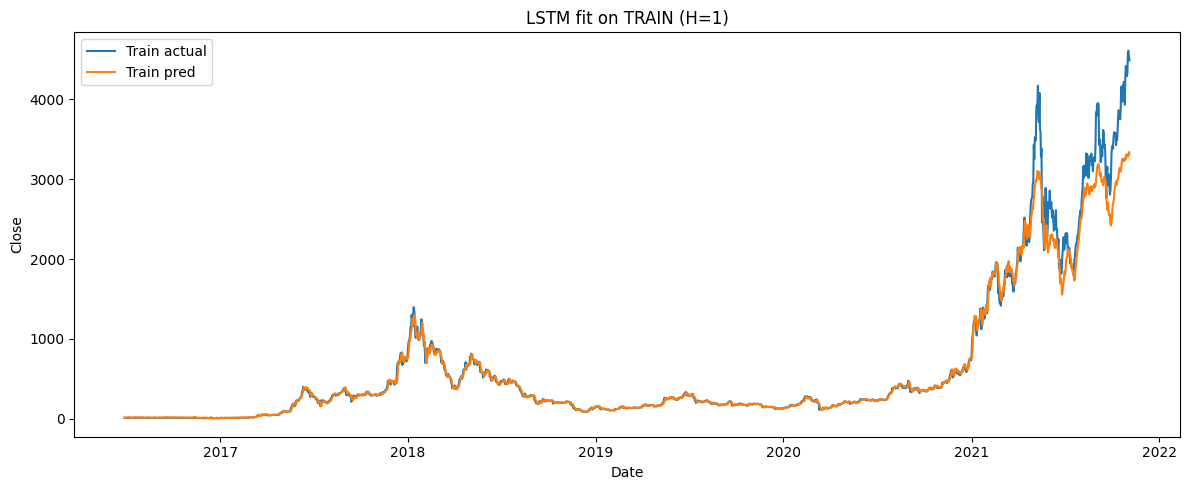

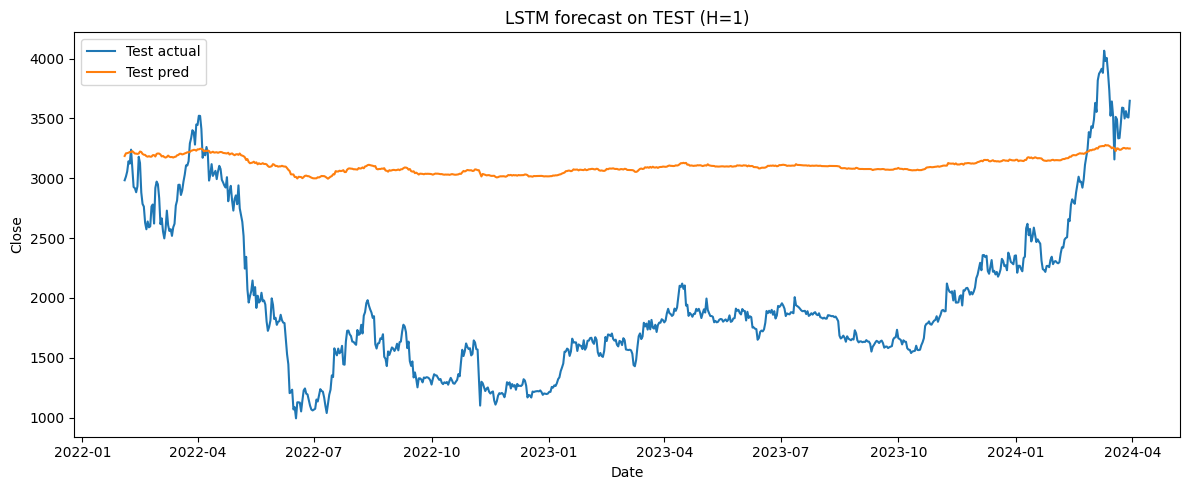

H=1 → Train RMSE=168.18, MAE=58.20, R²=0.966 | Test RMSE=1280.71, MAE=1181.31, R²=-3.084

Fitting final model for H=5 with: {'lookback': 90, 'units': 160, 'layers': 1, 'dropout': 0.3, 'opt': 'rmsprop', 'lr': 0.001517668, 'batch': 64, 'epochs': 150, 'pat': 5, 'scaler': 'standard'}
Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2506 - val_loss: 0.5208 - learning_rate: 0.0015
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0388 - val_loss: 0.2957 - learning_rate: 0.0015
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0116 - val_loss: 0.4844 - learning_rate: 0.0015
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - val_loss: 0.2285 - learning_rate: 0.0015
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - val_loss: 0.3732 - learning_rate: 0.0015
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - val_loss: 1.2783 - learning_rate: 0.0015
Epoch 7/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 

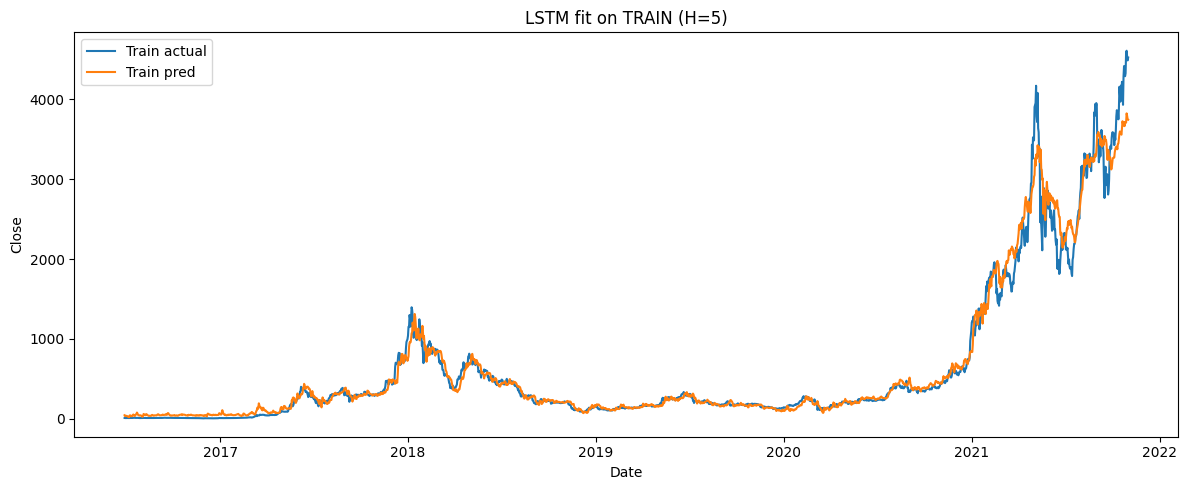

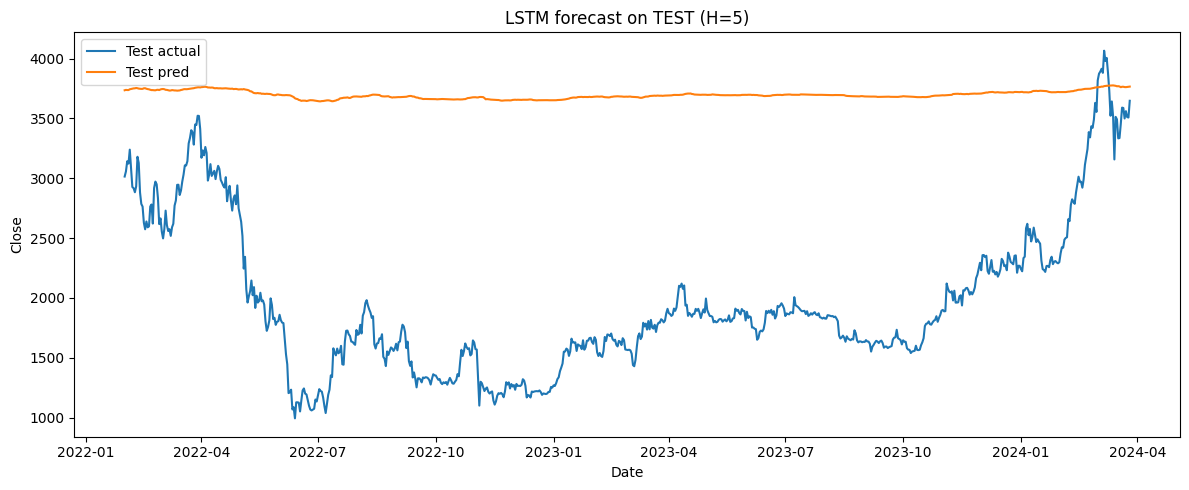

H=5 → Train RMSE=146.57, MAE=74.09, R²=0.975 | Test RMSE=1839.63, MAE=1741.51, R²=-7.444

Fitting final model for H=15 with: {'lookback': 90, 'units': 128, 'layers': 1, 'dropout': 0.4, 'opt': 'rmsprop', 'lr': 0.005820295, 'batch': 128, 'epochs': 100, 'pat': 4, 'scaler': 'standard'}
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 2.5300 - val_loss: 1.7903 - learning_rate: 0.0058
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0682 - val_loss: 1.9130 - learning_rate: 0.0058
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0410 - val_loss: 1.2790 - learning_rate: 0.0058
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0292 - val_loss: 2.8662 - learning_rate: 0.0058
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1215 - val_loss: 6.5997 - learning_rate: 0.0058
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0508 - val_loss: 3.8690 - learning_rate: 0.0029
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - los

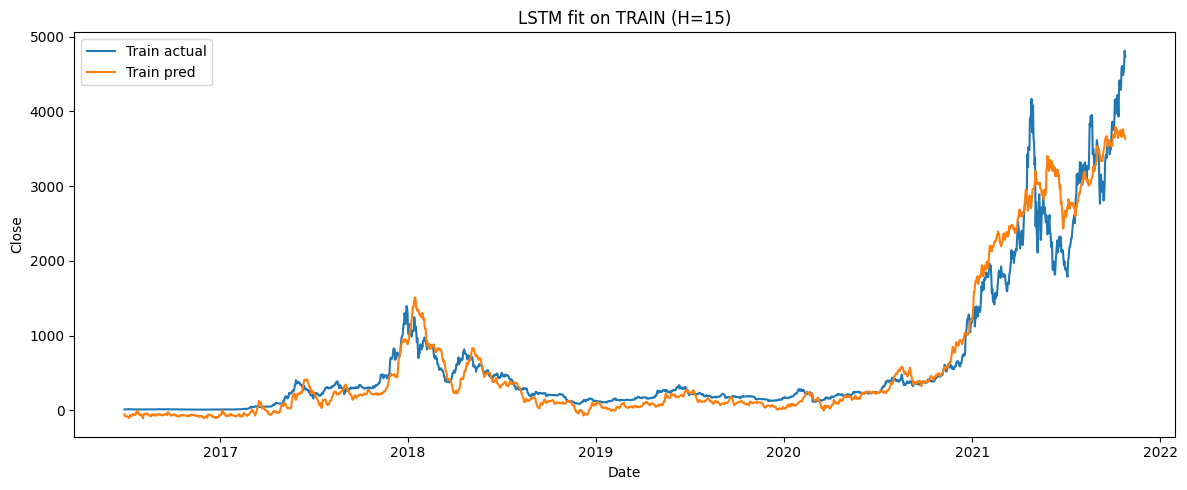

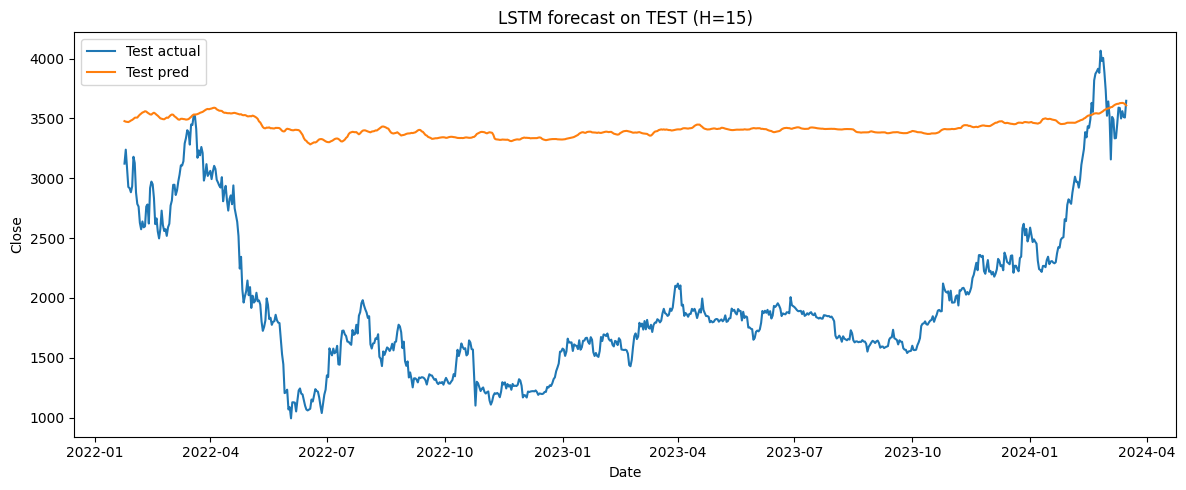

H=15 → Train RMSE=247.76, MAE=153.93, R²=0.930 | Test RMSE=1569.75, MAE=1472.59, R²=-5.198


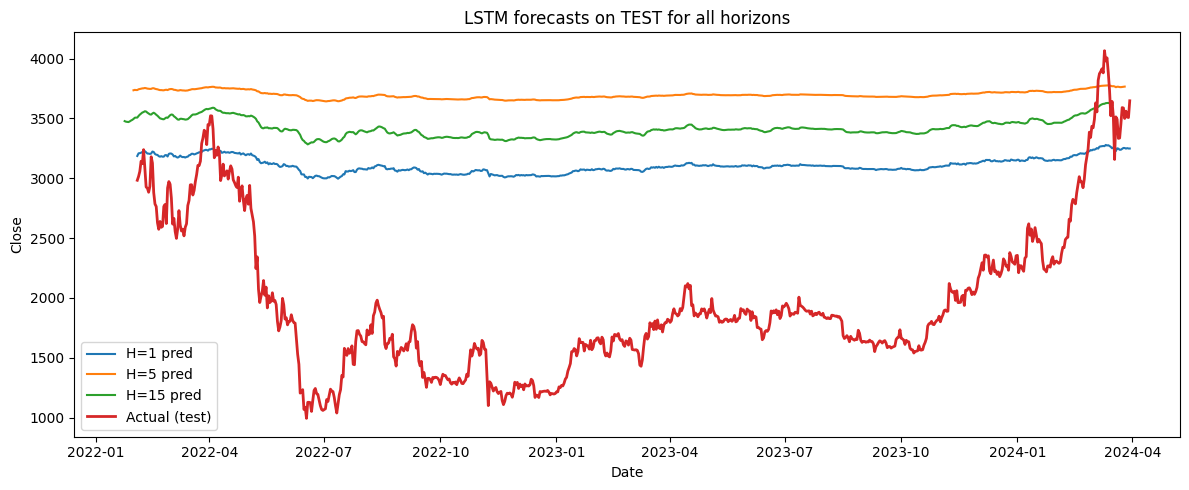

In [ ]:
# Final fit and  predictions on TRAIN/TEST

def fit_final_and_predict_forexog(df, FEATURES, H, best, train_frac=0.70,
                                  exog_method="naive", season=7):
    data = df.copy().sort_index()
    data["y"] = data["Close"].shift(-H)
    data = data.dropna(subset=["y"])

    cut = int(len(data) * train_frac)
    train, test = data.iloc[:cut].copy(), data.iloc[cut:].copy()

    Xsc, Ysc = get_scalers(best.get("scaler", "standard"))

    # Train scaling
    Xtr = Xsc.fit_transform(train[FEATURES].astype("float32"))
    ytr = Ysc.fit_transform(train["y"].values.reshape(-1, 1)).ravel()

    # Forecast exogs for the TEST block
    exog_cols = [c for c in FEATURES if c != "Close"]
    exog_fc = forecast_exogs_block(train, horizon=len(test),
                                   exog_cols=exog_cols,
                                   method=exog_method, season=season)

    Xte_raw = test[FEATURES].copy()
    for c in exog_cols:
        Xte_raw[c] = exog_fc[c].values  # overwrite realized values with forecasts

    Xte = Xsc.transform(Xte_raw.astype("float32"))
    yte = Ysc.transform(test["y"].values.reshape(-1, 1)).ravel()

    LB = best["lookback"]
    Xtr_seq, ytr_seq = make_windows(Xtr, ytr, LB)
    Xte_seq, yte_seq = make_windows(Xte, yte, LB)

    # Train model
    model = build_lstm(Xtr_seq.shape[-1], LB, best)
    es = tf.keras.callbacks.EarlyStopping("val_loss", patience=best["pat"], restore_best_weights=True)
    rl = tf.keras.callbacks.ReduceLROnPlateau("val_loss", factor=0.5,
                                              patience=max(1, best["pat"] // 2),
                                              min_lr=1e-5, verbose=0)

    model.fit(Xtr_seq, ytr_seq,
              validation_split=0.1,
              epochs=best["epochs"], batch_size=best["batch"],
              verbose=1, callbacks=[es, rl], shuffle=False)

    # Predictions
    pred_tr  = Ysc.inverse_transform(model.predict(Xtr_seq, verbose=0)).ravel()
    pred_te  = Ysc.inverse_transform(model.predict(Xte_seq, verbose=0)).ravel()
    ytr_true = Ysc.inverse_transform(ytr_seq.reshape(-1, 1)).ravel()
    yte_true = Ysc.inverse_transform(yte_seq.reshape(-1, 1)).ravel()

    # Align dates
    train_dates = train.index[LB - 1 : LB - 1 + len(ytr_seq)]
    test_dates  = test.index [LB - 1 : LB - 1 + len(yte_seq)]

    train_df = pd.DataFrame({"Date": train_dates, "y_true": ytr_true, "y_pred": pred_tr}).set_index("Date")
    test_df  = pd.DataFrame({"Date": test_dates,  "y_true": yte_true, "y_pred": pred_te}).set_index("Date")

    return model, train_df, test_df

def plot_fit(train_df, test_df, H):
    # TRAIN
    plt.figure(figsize=(12, 5))
    plt.plot(train_df.index, train_df["y_true"], label="Train actual")
    plt.plot(train_df.index, train_df["y_pred"], label="Train pred")
    plt.title(f"LSTM fit on TRAIN (H={H})"); plt.xlabel("Date"); plt.ylabel("Close")
    plt.legend(); plt.tight_layout(); plt.show()
    # TEST
    plt.figure(figsize=(12, 5))
    plt.plot(test_df.index, test_df["y_true"], label="Test actual")
    plt.plot(test_df.index, test_df["y_pred"], label="Test pred")
    plt.title(f"LSTM forecast on TEST (H={H})"); plt.xlabel("Date"); plt.ylabel("Close")
    plt.legend(); plt.tight_layout(); plt.show()
    # Metrics
    tr_rmse = rmse(train_df["y_true"], train_df["y_pred"])
    tr_mae  = mean_absolute_error(train_df["y_true"], train_df["y_pred"])
    tr_r2   = r2_score(train_df["y_true"], train_df["y_pred"])
    te_rmse = rmse(test_df["y_true"], test_df["y_pred"])
    te_mae  = mean_absolute_error(test_df["y_true"], test_df["y_pred"])
    te_r2   = r2_score(test_df["y_true"], test_df["y_pred"])
    print(f"H={H} → Train RMSE={tr_rmse:.2f}, MAE={tr_mae:.2f}, R²={tr_r2:.3f} | "
          f"Test RMSE={te_rmse:.2f}, MAE={te_mae:.2f}, R²={te_r2:.3f}")


# Prep your DataFrame and FEATURES
assert isinstance(df.index, pd.DatetimeIndex), "df must be indexed by Date"
assert "Close" in df.columns, "df must contain 'Close'"
assert all(c in df.columns for c in FEATURES), f"Missing features: {set(FEATURES) - set(df.columns)}"


# Robust evaluation with rolling origin

HORIZONS = (1, 5, 15)
for H in HORIZONS:
    metrics_wf, (y_true_wf, y_pred_wf) = rolling_origin_eval_wf_forexog(
        df=df, FEATURES=FEATURES, H=H, params=results[H][0],
        train_frac=0.70, step=max(5, H)  # e.g., weekly step or ≥ horizon
    )
    print(f"H={H} (walk-origin) → RMSE={metrics_wf['RMSE']:.2f}, "
          f"MAE={metrics_wf['MAE']:.2f}, R²={metrics_wf['R2']:.3f}")


# Final fit  and plots

final_models = {}
for H in HORIZONS:
    best = results[H][0]
    print(f"\nFitting final model for H={H} with: {best}")
    model, tr_df, te_df = fit_final_and_predict_forexog(df, FEATURES, H, best, train_frac=0.70)
    final_models[H] = {"model": model, "train": tr_df, "test": te_df}
    plot_fit(tr_df, te_df, H)
    tr_df.to_csv(f"lstm_H{H}_train_preds.csv")
    te_df.to_csv(f"lstm_H{H}_test_preds.csv")

# overlay all TEST predictions
plt.figure(figsize=(12,5))
for H, out in final_models.items():
    plt.plot(out["test"].index, out["test"]["y_pred"], label=f"H={H} pred")
plt.plot(list(final_models.values())[0]["test"].index,
         list(final_models.values())[0]["test"]["y_true"],
         label="Actual (test)", linewidth=2)
plt.title("LSTM forecasts on TEST for all horizons")
plt.xlabel("Date"); plt.ylabel("Close"); plt.legend(); plt.tight_layout(); plt.show()



# Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/896zk6sf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/a7s7kd50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27394', 'data', 'file=/tmp/tmpok394mn4/896zk6sf.json', 'init=/tmp/tmpok394mn4/a7s7kd50.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelan5neflj/prophet_model-20250907234557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok

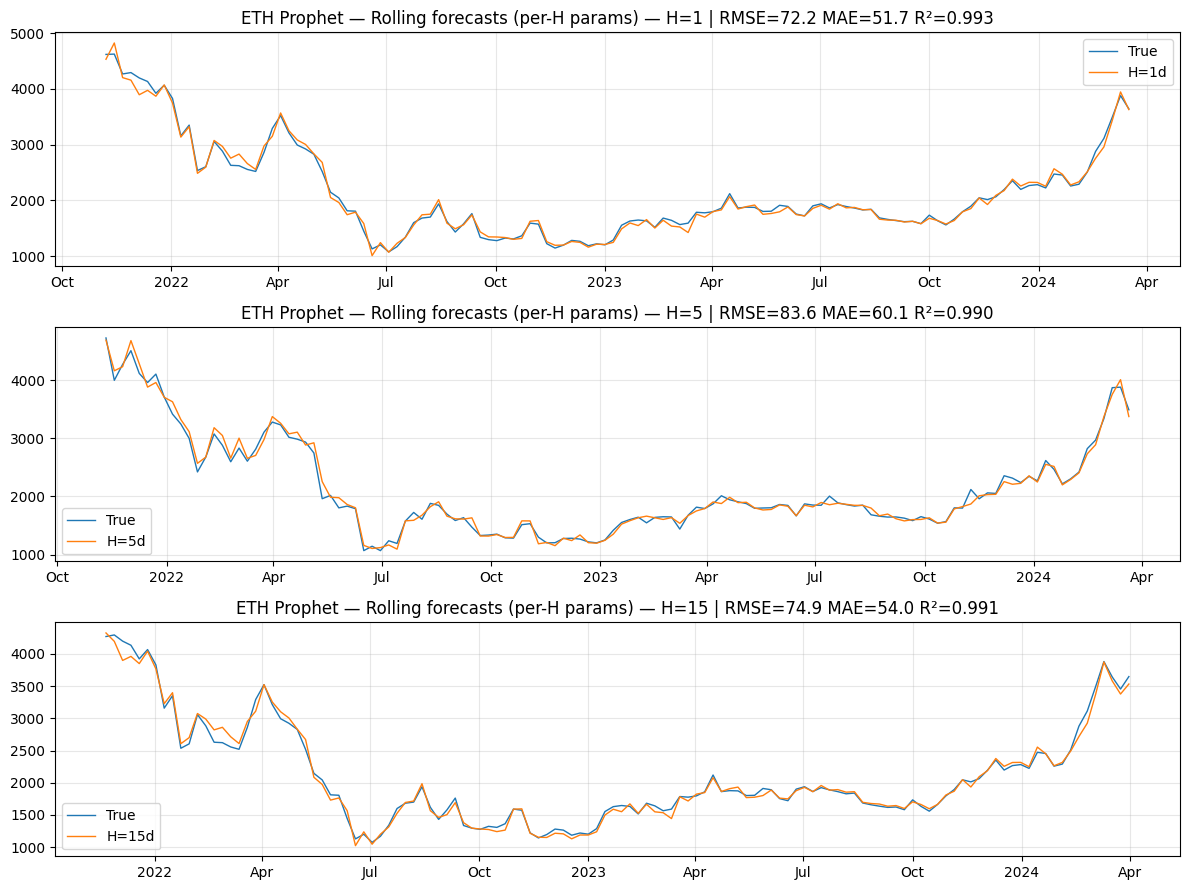

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/teaelgx5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/b3dukvsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3565', 'data', 'file=/tmp/tmpok394mn4/teaelgx5.json', 'init=/tmp/tmpok394mn4/b3dukvsi.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelapfc_wfe/prophet_model-20250907235526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:55:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:55:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok3

H=1: RMSE=104.59, MAE=45.95, R²=0.988, N=241


23:59:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/qb5t0pfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/9xc6bv5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61284', 'data', 'file=/tmp/tmpok394mn4/qb5t0pfz.json', 'init=/tmp/tmpok394mn4/9xc6bv5u.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelyqzvwhn4/prophet_model-20250907235939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
23:59:39 - cmdstanpy - ERROR - Chain [1] erro

H=5: RMSE=101.79, MAE=44.09, R²=0.989, N=240


00:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/wspbtiqm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/ac3tpa8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88396', 'data', 'file=/tmp/tmpok394mn4/wspbtiqm.json', 'init=/tmp/tmpok394mn4/ac3tpa8o.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelx653tljh/prophet_model-20250908000529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:05:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run

H=15: RMSE=73.02, MAE=36.13, R²=0.994, N=239


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from prophet import Prophet

# ========== Hyperparameters per horizon (from Bitcoin tuning) ==========
BEST_PARAMS_BY_H = {
    1: {
        'changepoint_prior_scale': 0.1,
        'seasonality_prior_scale': 10.0,
        'seasonality_mode': 'multiplicative',
        'changepoint_range': 0.8
    },
    5: {
        'changepoint_prior_scale': 0.001,
        'seasonality_prior_scale': 0.01,
        'seasonality_mode': 'additive',
        'changepoint_range': 0.8
    },
    15: {
        'changepoint_prior_scale': 0.1,
        'seasonality_prior_scale': 0.01,
        'seasonality_mode': 'additive',
        'changepoint_range': 0.9
    }
}

HORIZONS = (1, 5, 15)
INTERVAL_WIDTH = 0.80
REG_PRIOR = 0.10
REFIT_EVERY = 7  # weekly refit

# ========== Metric helpers ==========
def _rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def _mae(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return float(np.mean(np.abs(y_true - y_pred)))

def _r2(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

# ========== Data helpers ==========
def build_prophet_frame(raw_df, exog_cols, target='Close', lag=1):
    """
    Create a Prophet-ready DataFrame with lagged exogenous variables.
    """
    dfp = raw_df[[target] + exog_cols].copy()
    dfp[target] = pd.to_numeric(dfp[target], errors='coerce')
    dfp['ds'] = raw_df.index
    dfp['y'] = dfp[target]
    dfp = dfp[['ds', 'y'] + exog_cols].sort_values('ds').reset_index(drop=True)

    dfp['ds'] = pd.to_datetime(dfp['ds'])
    dfp = dfp.set_index('ds').asfreq('D').reset_index()

    # lag exogenous features by 1 day
    for c in exog_cols:
        dfp[c] = pd.to_numeric(dfp[c], errors='coerce').shift(lag)

    dfp[exog_cols] = dfp[exog_cols].ffill().bfill()
    dfp = dfp.dropna(subset=['y'] + exog_cols).reset_index(drop=True)
    return dfp

def train_test_split_prophet(dfp, train_frac):
    cut = int(len(dfp) * train_frac)
    return dfp.iloc[:cut].copy(), dfp.iloc[cut:].copy()

# ========== Model helper ==========
def make_model(params, exog_cols, interval_width=INTERVAL_WIDTH, reg_prior=REG_PRIOR):
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        changepoint_range=params['changepoint_range'],
        yearly_seasonality=True,
        weekly_seasonality=True,
        interval_width=interval_width
    )
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    for reg in exog_cols:
        m.add_regressor(reg, standardize='auto', prior_scale=reg_prior)
    return m

# ========== Rolling forecast (out-of-sample) ==========
def rolling_k_ahead(df_prophet, exog_cols, train_len, best_params, horizons=HORIZONS,
                    refit_every=REFIT_EVERY, interval_width=INTERVAL_WIDTH, reg_prior=REG_PRIOR):
    preds = {h: [] for h in horizons}
    dates = {h: [] for h in horizons}
    ytrue = {h: [] for h in horizons}

    i = int(train_len)
    max_h = max(horizons)

    while i + max_h - 1 < len(df_prophet):
        hist = df_prophet.iloc[:i].copy()

        # Fit per-horizon models
        future_full = df_prophet[['ds'] + exog_cols].iloc[i:i+max_h].copy()
        fcst_by_h = {}
        for h in horizons:
            params_h = best_params[h]
            m = make_model(params_h, exog_cols, interval_width=interval_width, reg_prior=reg_prior)
            m.fit(hist[['ds','y'] + exog_cols])
            fcst = m.predict(future_full)[['ds','yhat']].reset_index(drop=True)
            fcst_by_h[h] = fcst

        # Collect predictions
        for h in horizons:
            idx = h - 1
            dates[h].append(fcst_by_h[h].loc[idx, 'ds'])
            preds[h].append(float(fcst_by_h[h].loc[idx, 'yhat']))
            ytrue[h].append(float(df_prophet['y'].iloc[i + idx]))

        i += refit_every

    out = {h: pd.DataFrame({'ds': dates[h], 'y_true': ytrue[h], 'y_pred': preds[h]})
           for h in horizons}
    return out

# ========== Rolling in-sample forecast ==========
def rolling_k_in_sample_prophet(train_df, exog_cols, params, H, refit_every=REFIT_EVERY,
                                interval_width=INTERVAL_WIDTH, reg_prior=REG_PRIOR):
    preds, trues, dates = [], [], []
    i = 365  # start forecasting after 1 year of data

    while i + H <= len(train_df):
        hist = train_df.iloc[:i].copy()

        m = make_model(params, exog_cols, interval_width=interval_width, reg_prior=reg_prior)
        m.fit(hist[['ds','y'] + exog_cols])

        future = train_df[['ds'] + exog_cols].iloc[i:i + H].copy()
        fcst = m.predict(future)[['ds','yhat']].reset_index(drop=True)

        preds.append(float(fcst.loc[H - 1, 'yhat']))
        trues.append(float(train_df['y'].iloc[i + H - 1]))
        dates.append(train_df['ds'].iloc[i + H - 1])

        i += refit_every

    df_out = pd.DataFrame({'ds': dates, 'y_true': trues, 'y_pred': preds})
    rmse = _rmse(df_out['y_true'], df_out['y_pred'])
    mae = _mae(df_out['y_true'], df_out['y_pred'])
    r2 = _r2(df_out['y_true'], df_out['y_pred'])
    metrics = {"RMSE": rmse, "MAE": mae, "R2": r2, "N": len(df_out)}
    return df_out, metrics

# ========== Example usage ==========
# 1. Load your Ethereum data (DataFrame with DatetimeIndex and columns like Open, High, Low, Close, Volume, etc.)
# data_eth = pd.read_csv('your_ethereum_data.csv', index_col='Date', parse_dates=True)

# 2. List of exogenous variables present in your dataset
candidate_exogs = [
    'Open','High','Low','Volume','Pct_change','MA','EMA','OBV',
    'MACD','Signal','PSAR','GPRD','EPU','gold_close'
]
exog_cols = [c for c in candidate_exogs if c in data_eth.columns]

# 3. Build Prophet-ready frame and split
df_prophet_eth = build_prophet_frame(data_eth, exog_cols, target='Close', lag=1)
train_df_eth, test_df_eth = train_test_split_prophet(df_prophet_eth, 0.70)

# 4. Rolling out-of-sample forecasts using per-horizon parameters
series_eth = rolling_k_ahead(
    df_prophet=df_prophet_eth,
    exog_cols=exog_cols,
    train_len=len(train_df_eth),
    best_params=BEST_PARAMS_BY_H,
    horizons=HORIZONS,
    refit_every=REFIT_EVERY,
    interval_width=INTERVAL_WIDTH,
    reg_prior=REG_PRIOR
)

# Plot rolling forecasts (optional)
def plot_rolling(series_dict, title_prefix="Prophet Rolling forecasts"):
    Hs = sorted(series_dict.keys())
    n  = len(Hs)
    fig, axes = plt.subplots(n, 1, figsize=(12, 3.0*n), sharex=False)
    if n == 1:
        axes = [axes]

    for ax, h in zip(axes, Hs):
        dfh = series_dict[h].sort_values('ds')
        rmse = _rmse(dfh['y_true'], dfh['y_pred'])
        mae  = _mae(dfh['y_true'], dfh['y_pred'])
        r2   = _r2(dfh['y_true'], dfh['y_pred'])
        ax.plot(dfh['ds'], dfh['y_true'], label='True', linewidth=1)
        ax.plot(dfh['ds'], dfh['y_pred'], label=f'H={h}d', linewidth=1)
        ax.set_title(f"{title_prefix} — H={h} | RMSE={rmse:.1f} MAE={mae:.1f} R²={r2:.3f}")
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    plt.tight_layout()
    plt.show()

# Show the plots
plot_rolling(series_eth, title_prefix="ETH Prophet — Rolling forecasts (per-H params)")

# 5. (Optional) In-sample evaluation for each horizon
for H in HORIZONS:
    df_h, mets_h = rolling_k_in_sample_prophet(
        train_df=train_df_eth,
        exog_cols=exog_cols,
        params=BEST_PARAMS_BY_H[H],
        H=H,
        refit_every=REFIT_EVERY
    )
    print(f"H={H}: RMSE={mets_h['RMSE']:.2f}, MAE={mets_h['MAE']:.2f}, R²={mets_h['R2']:.3f}, N={mets_h['N']}")


# PROPHET_LSTM

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/i06kqhxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/he47oeln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81296', 'data', 'file=/tmp/tmpok394mn4/i06kqhxh.json', 'init=/tmp/tmpok394mn4/he47oeln.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modeloh578q7w/prophet_model-20250908002037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:20:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality

Training sample performance:


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/hpv4qiai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/ex3lzsyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20247', 'data', 'file=/tmp/tmpok394mn4/hpv4qiai.json', 'init=/tmp/tmpok394mn4/ex3lzsyn.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelkdsz3kx8/prophet_model-20250908003857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:38:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily

Training sample | Horizon=1 -> RMSE=68.20, MAE=29.07, R²=0.994


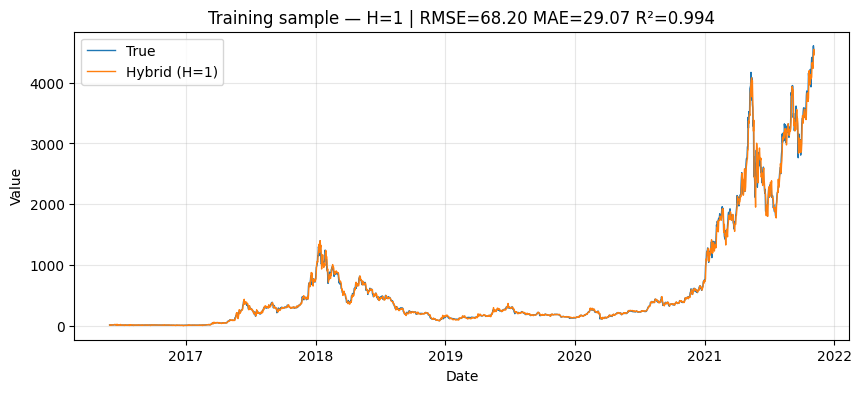

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/u1o7h250.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/e401fc4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98896', 'data', 'file=/tmp/tmpok394mn4/u1o7h250.json', 'init=/tmp/tmpok394mn4/e401fc4o.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelaazp50mq/prophet_model-20250908011626.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:16:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily

Training sample | Horizon=5 -> RMSE=150.96, MAE=62.87, R²=0.973


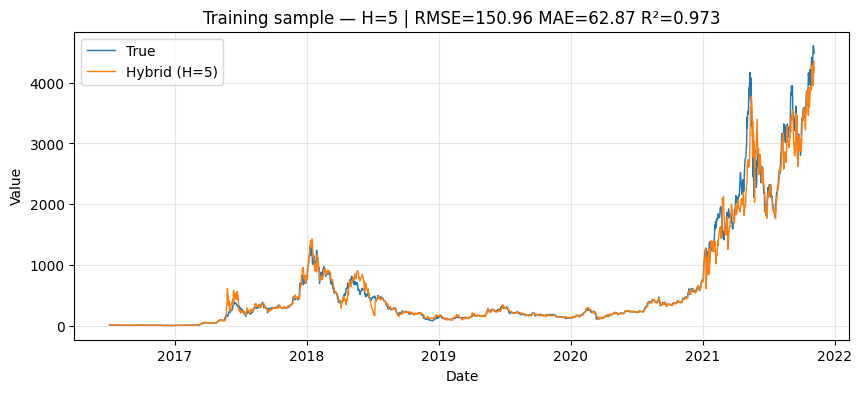

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
01:56:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/7ve57goh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/pbzfvios.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35046', 'data', 'file=/tmp/tmpok394mn4/7ve57goh.json', 'init=/tmp/tmpok394mn4/pbzfvios.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelki8n1kk0/prophet_model-20250908015646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:56:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:56:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmd

Training sample | Horizon=15 -> RMSE=75.03, MAE=36.53, R²=0.993


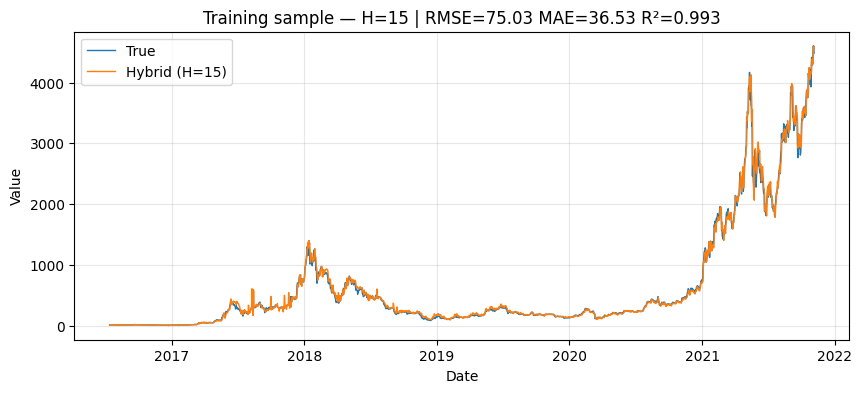

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/1tc7x2ua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/hthhtgnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88186', 'data', 'file=/tmp/tmpok394mn4/1tc7x2ua.json', 'init=/tmp/tmpok394mn4/hthhtgnt.json', 'output', 'file=/tmp/tmpok394mn4/prophet_model4dxl5_wk/prophet_model-20250908021949.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Test sample performance:


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/xi64z3ln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63036', 'data', 'file=/tmp/tmpok394mn4/qcu6y1wf.json', 'init=/tmp/tmpok394mn4/xi64z3ln.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelwo1dur7m/prophet_model-20250908022233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tem

Test sample | Horizon=1 -> RMSE=102.96, MAE=67.73, R²=0.975


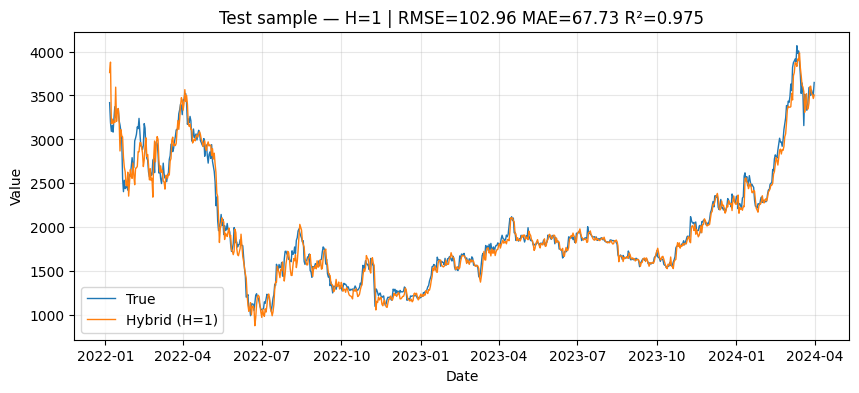

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
02:30:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:30:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/nbhjt6da.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/zl7k_equ.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64272', 'data', 'file=/tmp/tmpok394mn4/nbhjt6da.json', 'init=/tmp/tmpok394mn4/zl7k_equ.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelol_mkrrn/prophet_model-20250908023014.csv', 'method=optimi

Test sample | Horizon=5 -> RMSE=106.89, MAE=71.01, R²=0.971


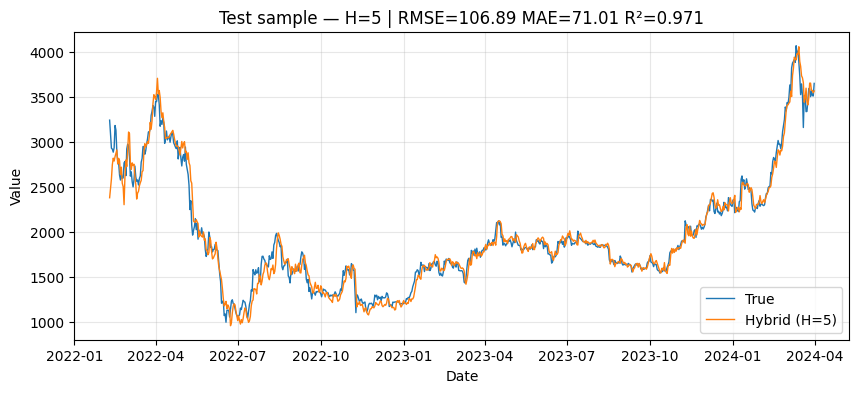

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65690', 'data', 'file=/tmp/tmpok394mn4/wm2jmjs6.json', 'init=/tmp/tmpok394mn4/2geqfhcb.json', 'output', 'file=/tmp/tmpok394mn4/prophet_modelrka1ieof/prophet_model-20250908024810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:48:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
02:48:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/7bkonqh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpok394mn4/c377emqo.json
DEBUG:cmd

Test sample | Horizon=15 -> RMSE=302.23, MAE=134.91, R²=0.764


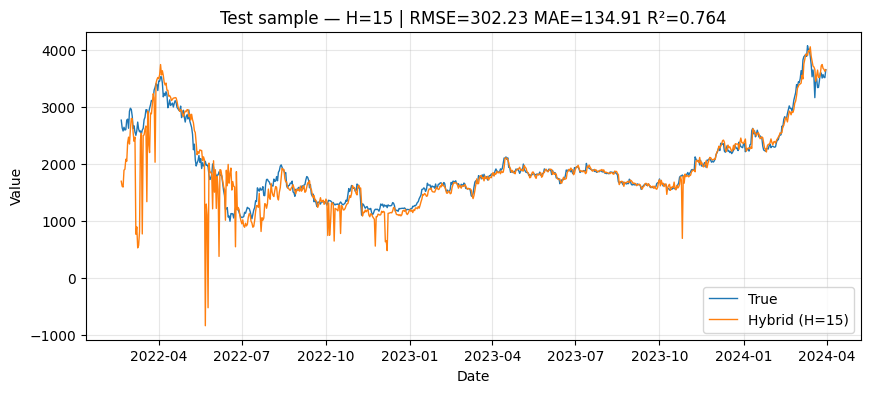

In [ ]:
import numpy as np
import pandas as pd
from prophet import Prophet
from tensorflow.keras import models, layers, callbacks, optimizers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Configuration
# -------------------------------------------------------
HORIZONS = (1, 5, 15)
TRAIN_FRAC = 0.70
INTERVAL_WIDTH = 0.80
REFIT_EVERY = 7
REG_PRIOR = 0.10
PATIENCE = 10
EPOCHS = 200

# Prophet hyper-parameters tuned on Bitcoin (per horizon)
best_by_H = {
    1: {'changepoint_prior_scale': 0.1,   'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive',     'changepoint_range': 0.9},
    5: {'changepoint_prior_scale': 0.1,   'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative','changepoint_range': 0.8},
    15:{'changepoint_prior_scale': 0.001,'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive',     'changepoint_range': 0.8}
}

# LSTM hyper-parameters tuned on Bitcoin (per horizon)
fixed_lstm_params = {
    1:  {'units': 32,  'dropout': 0.2, 'lr': 0.001,  'batch_size': 16, 'lookback': 60},
    5:  {'units': 32,  'dropout': 0.1, 'lr': 0.0001, 'batch_size': 32, 'lookback': 90},
    15: {'units': 128, 'dropout': 0.1, 'lr': 0.001,  'batch_size': 16, 'lookback': 90}
}

# -------------------------------------------------------
# Helper functions
# -------------------------------------------------------
def build_prophet_frame(raw_df, exog_cols, target='Close', lag=1):
    """Prepare a Prophet-ready DataFrame with lagged exogenous variables."""
    dfp = raw_df[[target] + exog_cols].copy()
    dfp[target] = pd.to_numeric(dfp[target], errors='coerce')
    dfp['ds'] = raw_df.index
    dfp['y']  = dfp[target]
    dfp = dfp[['ds','y'] + exog_cols].sort_values('ds').reset_index(drop=True)
    dfp['ds'] = pd.to_datetime(dfp['ds'])
    dfp = dfp.set_index('ds').asfreq('D').reset_index()
    for c in exog_cols:
        dfp[c] = pd.to_numeric(dfp[c], errors='coerce').shift(lag)
    dfp[exog_cols] = dfp[exog_cols].ffill().bfill()
    return dfp.dropna(subset=['y'] + exog_cols).reset_index(drop=True)

def train_test_split_prophet(dfp, train_frac):
    cut = int(len(dfp) * train_frac)
    return dfp.iloc[:cut].copy(), dfp.iloc[cut:].copy()

def make_model(params, exog_cols, interval_width=INTERVAL_WIDTH, reg_prior=REG_PRIOR):
    """Create a Prophet model with specified hyper-parameters and regressors."""
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        changepoint_range=params['changepoint_range'],
        interval_width=interval_width,
        mcmc_samples=0
    )
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    for reg in exog_cols:
        m.add_regressor(reg, standardize='auto', prior_scale=reg_prior)
    return m

def build_supervised_residuals(resid_series, exog_df, lookback, horizon):
    """Build supervised dataset from residuals and exogenous variables."""
    s = resid_series.copy()
    X_resid, X_exog, y, dates = [], [], [], []
    for t in range(lookback, len(s) - horizon):
        X_resid.append(s.iloc[t-lookback:t].values.astype(float))
        X_exog.append(exog_df.iloc[t].values.astype(float))
        y.append(s.iloc[t + horizon])
        dates.append(s.index[t + horizon])
    X_resid = np.asarray(X_resid)
    X_exog  = np.asarray(X_exog)
    y       = np.asarray(y).reshape(-1, 1)
    dates   = np.asarray(dates)
    resid_scaler = StandardScaler()
    exog_scaler  = StandardScaler()
    y_scaler     = StandardScaler()
    return X_resid, X_exog, y, dates, resid_scaler, exog_scaler, y_scaler

def scale_and_reshape_for_lstm(X_resid, X_exog, y, resid_scaler, exog_scaler, y_scaler, fit=True):
    """Scale residual and exogenous inputs; reshape for LSTM (seq_len, n_features)."""
    n, L = X_resid.shape
    Xr_flat = X_resid.reshape(n, L)
    if fit:
        Xr_flat = resid_scaler.fit_transform(Xr_flat)
        Xe = exog_scaler.fit_transform(X_exog)
        y  = y_scaler.fit_transform(y)
    else:
        Xr_flat = resid_scaler.transform(Xr_flat)
        Xe = exog_scaler.transform(X_exog)
        y  = y_scaler.transform(y)
    Xe_rep = np.repeat(Xe[:, None, :], repeats=L, axis=1)
    Xr_seq = Xr_flat.reshape(n, L, 1)
    X_seq  = np.concatenate([Xr_seq, Xe_rep], axis=2)
    return X_seq, y

# Evaluation metrics
def _rmse(y, yhat):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    return float(np.sqrt(np.mean((y - yhat)**2)))

def _mae(y, yhat):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    return float(np.mean(np.abs(y - yhat)))

def _r2(y, yhat):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

def evaluate_and_plot(data_df, horizon, prophet_params, lstm_info, title_suffix):
    """Evaluate and plot hybrid forecasts for a given horizon."""
    preds, true_vals, dates_out = [], [], []
    lookback = lstm_info["lookback"]
    max_i = len(data_df) - horizon

    for i in range(lookback, max_i):
        # Expanding window training
        hist = data_df.iloc[:i].copy()
        future = data_df[['ds'] + exog_cols].iloc[i:i+horizon].copy()

        # Prophet model
        m = make_model(prophet_params, exog_cols)
        m.fit(hist[['ds','y'] + exog_cols])

        fcst = m.predict(future)[['ds','yhat']].reset_index(drop=True)
        yhat_ph = fcst.loc[horizon - 1, 'yhat']
        y_true_h = float(data_df['y'].iloc[i + horizon - 1])

        # Residual history for LSTM
        fit_hist = m.predict(hist[['ds'] + exog_cols])[['ds','yhat']]
        merged_h = hist[['ds','y']].merge(fit_hist, on='ds', how='inner').set_index('ds').sort_index()
        resid_hist = merged_h['y'] - merged_h['yhat']
        exog_hist = hist.set_index('ds')[exog_cols]

        if len(resid_hist) < lookback:
            continue

        r_win = resid_hist.iloc[-lookback:].values.reshape(1, -1)
        ex_row = exog_hist.iloc[-1].values.reshape(1, -1)

        X_seq, _ = scale_and_reshape_for_lstm(
            r_win, ex_row, np.array([[0.0]]),
            lstm_info["resid_scaler"],
            lstm_info["exog_scaler"],
            lstm_info["y_scaler"],
            fit=False
        )
        resid_pred_scaled = lstm_info["model"].predict(X_seq, verbose=0)
        resid_pred = lstm_info["y_scaler"].inverse_transform(resid_pred_scaled)[0, 0]

        hybrid_forecast = yhat_ph + resid_pred

        preds.append(hybrid_forecast)
        true_vals.append(y_true_h)
        dates_out.append(data_df['ds'].iloc[i + horizon - 1])

    rmse = _rmse(true_vals, preds)
    mae  = _mae(true_vals, preds)
    r2   = _r2(true_vals, preds)
    print(f"{title_suffix} | Horizon={horizon} -> RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")

    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(dates_out, true_vals, label='True', linewidth=1)
    plt.plot(dates_out, preds, label=f'Hybrid (H={horizon})', linewidth=1)
    plt.title(f"{title_suffix} — H={horizon} | RMSE={rmse:.2f} MAE={mae:.2f} R²={r2:.3f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

# -------------------------------------------------------
# Load and prepare your Ethereum data
# -------------------------------------------------------
# Use the variable 'data' or 'df' as your DataFrame
base_df = df.copy()

# Exogenous columns (keep only those present)
exog_cols = [
    'Open','High','Low','Volume','Pct_change',
    'MA','EMA','OBV','MACD','Signal','PSAR',
    'GPRD','EPU','gold_close'
]
exog_cols = [c for c in exog_cols if c in base_df.columns]

# Build Prophet-ready frame and split
df_prophet = build_prophet_frame(base_df, exog_cols, target='Close', lag=1)
train_df, test_df = train_test_split_prophet(df_prophet, TRAIN_FRAC)

# -------------------------------------------------------
# Fit base Prophet model on training set to get residuals
# -------------------------------------------------------
prophet_base = make_model(best_by_H[1], exog_cols)
prophet_base.fit(train_df[['ds','y'] + exog_cols])

fit_tr = prophet_base.predict(train_df[['ds'] + exog_cols])[['ds','yhat']]
merged_tr = train_df[['ds','y']].merge(fit_tr, on='ds', how='inner').set_index('ds').sort_index()
resid_tr = merged_tr['y'] - merged_tr['yhat']
exog_tr  = train_df.set_index('ds')[exog_cols]

# -------------------------------------------------------
# Train LSTM models with fixed hyper-parameters
# -------------------------------------------------------
lstm_pack = {}
for H in HORIZONS:
    cfg = fixed_lstm_params[H]
    Xr, Xe, y_r, _, resid_scaler, exog_scaler, y_scaler = \
        build_supervised_residuals(resid_tr, exog_tr, cfg['lookback'], H)
    X_seq, y_scaled = scale_and_reshape_for_lstm(
        Xr, Xe, y_r,
        resid_scaler, exog_scaler, y_scaler, fit=True
    )
    model = models.Sequential([
        layers.Input(shape=X_seq.shape[1:]),
        layers.LSTM(cfg['units'], return_sequences=False),
        layers.Dropout(cfg['dropout']),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=optimizers.Nadam(learning_rate=cfg['lr']),
        loss='mae'
    )
    es = callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor='val_loss')
    model.fit(
        X_seq, y_scaled,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=cfg['batch_size'],
        verbose=0,
        callbacks=[es]
    )
    lstm_pack[H] = {
        "model": model,
        "resid_scaler": resid_scaler,
        "exog_scaler": exog_scaler,
        "y_scaler": y_scaler,
        "lookback": cfg['lookback']
    }

# -------------------------------------------------------
# Evaluate hybrid model on training and test samples
# -------------------------------------------------------
print("Training sample performance:")
for H in HORIZONS:
    evaluate_and_plot(train_df, H, best_by_H[H], lstm_pack[H], title_suffix="Training sample")

print("Test sample performance:")
for H in HORIZONS:
    evaluate_and_plot(test_df, H, best_by_H[H], lstm_pack[H], title_suffix="Test sample")


# Geminie

In [ ]:
import google.generativeai as genai
from google.colab import userdata

try:
    api_key = userdata.get('BTCKEY')
    genai.configure(api_key=api_key)

    print("--- Modèles disponibles pour 'generateContent' ---")
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            print(m.name)
    print("-------------------------------------------------")
    print("\nCopiez l'un des noms ci-dessus (par ex. 'models/gemini-1.5-flash-latest')")

except Exception as e:
    print(f"Erreur lors de la récupération des modèles: {e}")

--- Modèles disponibles pour 'generateContent' ---
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-li

CSV file loaded successfully.
Data loaded and split successfully.
Test data runs from 2021-11-07 to 2024-04-01

Google API Key configured successfully.

--- Starting Final Walk-Forward Evaluation for LLM (1-Day Horizon) ---
Prediction for 2022-01-06: Success
Prediction for 2022-01-07: Success
Prediction for 2022-01-08: Success
Prediction for 2022-01-09: Success
Prediction for 2022-01-10: Success
Prediction for 2022-01-11: Success
Prediction for 2022-01-12: Success
Prediction for 2022-01-13: Success
Prediction for 2022-01-14: Success
Prediction for 2022-01-15: Success
Prediction for 2022-01-16: Success
Prediction for 2022-01-17: Success
Prediction for 2022-01-18: Success
Prediction for 2022-01-19: Success
Prediction for 2022-01-20: Success
Prediction for 2022-01-21: Success
Prediction for 2022-01-22: Success
Prediction for 2022-01-23: Success
Prediction for 2022-01-24: Success
Prediction for 2022-01-25: Success
Prediction for 2022-01-26: Success
Prediction for 2022-01-27: Success
Predic

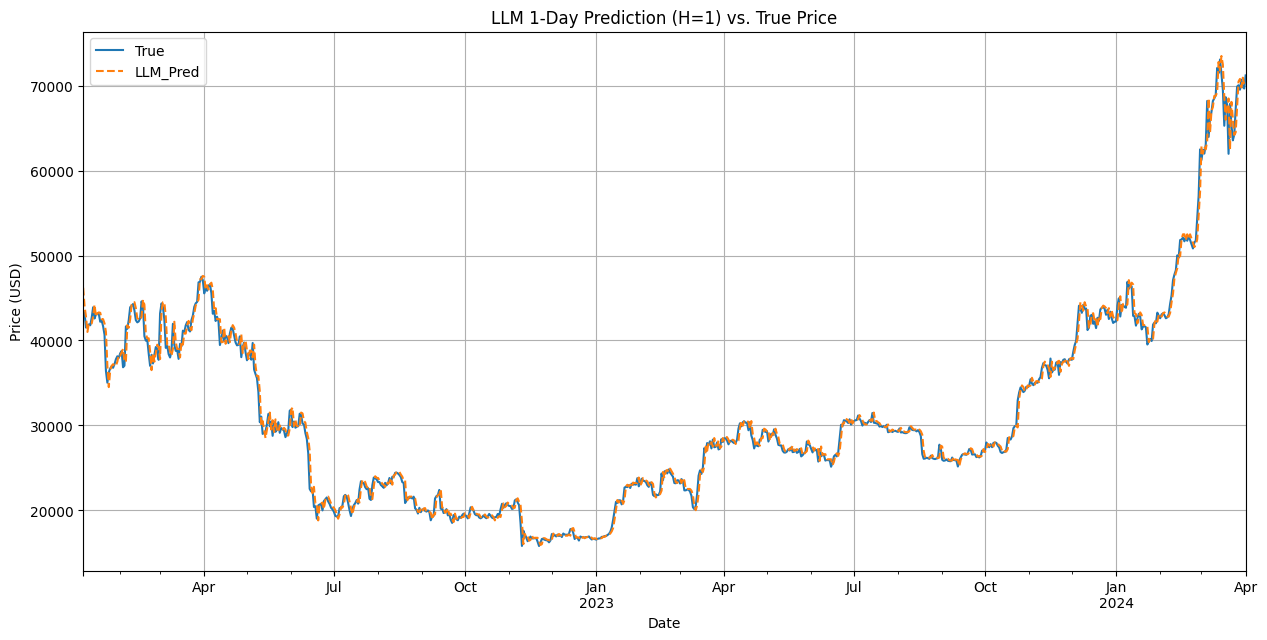

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
import re
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import userdata
import os

# 1. METHODOLOGY SETUP


# Clear proxies
os.environ['HTTP_PROXY'] = ''
os.environ['HTTPS_PROXY'] = ''
print("--- Proxy variables cleared ---")

# Basic parameters
N_STEPS = 60           # Context window
N_PRED_DAYS = 1        # Predict exactly 1 day
TRAIN_SPLIT_PCT = 0.70 # Strict 70/30 split

# 2. DATA LOADING & ROBUST SPLITTING

try:
    # Loading the Ethereum file
    df_final = pd.read_csv("data_eth.csv", parse_dates=['Date'])
    df_final.set_index('Date', inplace=True)

    # Strict Index Check
    if not df_final.index.is_monotonic_increasing:
        print("Sorting data by date...")
        df_final.sort_index(inplace=True)
    print("Ethereum CSV file loaded successfully.")
except FileNotFoundError:
    print("ERROR: File 'data_eth.csv' not found. Please ensure it is in the correct directory.")
    df_final = pd.DataFrame()

if not df_final.empty:
    # Calculate CUTOFF_DATE based on the 70/30 split
    total_rows = len(df_final)
    split_index = int(total_rows * TRAIN_SPLIT_PCT)

    # Robust Size Checks
    if split_index < N_STEPS:
        print(f"CRITICAL ERROR: Your 'train' split (70%) only contains {split_index} days.")
        df_final = pd.DataFrame()
    elif (total_rows - split_index) < N_PRED_DAYS:
         print(f"CRITICAL ERROR: Your 'test' split is too small for a {N_PRED_DAYS}-day forecast.")
         df_final = pd.DataFrame()
    else:
        CUTOFF_DATE = df_final.index[split_index]
        print("Data loaded and split successfully.")

if not df_final.empty:
    # Create the Evaluation Slice
    train_df = df_final[df_final.index < CUTOFF_DATE]
    test_start_index = split_index


    history_start_index = test_start_index - N_STEPS
    evaluation_df = df_final.iloc[history_start_index:]


    print(f"Test data runs from {evaluation_df.index.min().date()} to {evaluation_df.index.max().date()}")
    print(f"Cutoff Date (Train/Test Split): {CUTOFF_DATE.date()}")


# 3. LLM SETUP

try:
    api_key = userdata.get('ETHLLM')
    genai.configure(api_key=api_key)
    print("\nGoogle API Key configured successfully.")
    api_key_is_valid = True
except Exception as e:
    print(f"\nAPI Key configuration failed: {e}. The evaluation loop will be skipped.")
    api_key_is_valid = False


# 4. PROMPT ENGINEERING (H=1)


def serialize_data_for_llm(data_slice):
    """
    Converts a DataFrame slice into a richer text string for the LLM.
    """
    text_parts = []
    columns_to_include = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Pct_change', 'MA', 'EMA', 'OBV', 'MACD', 'Signal', 'PSAR', 'gold_close', 'EPU', 'GPRD'
    ]
    if not all(col in data_slice.columns for col in columns_to_include):
        missing_cols = [col for col in columns_to_include if col not in data_slice.columns]
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")

    for index in data_slice.index:
        row = data_slice.loc[index]
        daily_data = [f"J {index.strftime('%Y-%m-%d')}:"]
        for col in columns_to_include:
            if col == 'Volume':
                vol_in_mil = float(row[col]) / 1_000_000
                daily_data.append(f"V={vol_in_mil:.2f}M")
            else:
                daily_data.append(f"{col}={row[col]:.2f}")
        text_parts.append(" ".join(daily_data))
    return "; ".join(text_parts)

def create_llm_prompt(historical_data, target_date):
    """
    Creates a prompt for a single 1-day Ethereum forecast.
    """
    one_shot_context = "J 2024-12-01: Open=3500.50 High=3600.00 Low=3480.25 Close=3550.75 V=4500.50M Pct_change=0.02 MA=3400.00 EMA=3450.00 OBV=1234567890.12 MACD=50.55 Signal=45.20 PSAR=3300.00 gold_close=2300.00 EPU=85.54 GPRD=165.62; ... etc. for 59 more days"

    # Example now shows exactly 1 value
    one_shot_response = "3560.50"

    prompt = f"""You are a financial forecasting bot. Your task is to predict the closing price for Ethereum for the next 1 day.
Respond with ONLY a single numerical value. Do not add any extra text.

### Example
Context: {one_shot_context}
Target Closing Price: {one_shot_response}

### Prediction Task
Context: {serialize_data_for_llm(historical_data)}
Target Closing Price for {target_date.strftime('%Y-%m-%d')}:
"""
    return prompt


# 5. WALK-FORWARD EVALUATION LOOP


if api_key_is_valid and not df_final.empty:
    print(f"\n--- Starting Final Walk-Forward Evaluation for LLM ({N_PRED_DAYS}-Day Horizon) ---")

    llm_predictions = []

    # Calculate range based on available evaluation data
    test_range = range(len(evaluation_df) - N_STEPS - N_PRED_DAYS + 1)

    # Use flash model
    model_llm = genai.GenerativeModel('gemini-1.5-flash')

    for i in test_range:
        history_end_index = i + N_STEPS
        prediction_index = history_end_index + N_PRED_DAYS - 1

        history_unscaled = evaluation_df.iloc[i:history_end_index]

        target_date = evaluation_df.index[prediction_index]
        true_value = evaluation_df.iloc[prediction_index]['Close']

        # Create prompt
        prompt = create_llm_prompt(history_unscaled, target_date)

        llm_preds_float = None
        max_retries = 3

        for attempt in range(max_retries):
            try:
                response = model_llm.generate_content(prompt)
                parsed_preds = re.findall(r'-?\d+\.?\d*', response.text)

                if len(parsed_preds) >= 1:
                    llm_preds_float = [float(parsed_preds[0])]
                    break
                else:
                    raise ValueError(f"Expected 1 prediction, but got {len(parsed_preds)}: '{response.text}'")

            except Exception as e:
                print(f"API call failed (Attempt {attempt + 1}/{max_retries}) for date {target_date.date()}. Error: {e}")
                if attempt < max_retries - 1:
                    time.sleep(5)
                else:
                    print(f"Prediction failed after {max_retries} attempts for {target_date.date()}.")

        if llm_preds_float:

            print(f"Prediction for {target_date.date()} -> {target_date.date()}: Success")

            llm_predictions.append({
                'Date': target_date,
                'True': true_value,
                'LLM_Pred': llm_preds_float[0]
            })

        time.sleep(10) # Respect rate limits
else:
    print("\nThe evaluation loop is skipped due to an invalid API key or data loading failure.")

# 6. RESULTS ANALYSIS


if 'llm_predictions' in locals() and llm_predictions:
    results_df = pd.DataFrame(llm_predictions).set_index('Date')

    if not results_df.empty:
        y_true = results_df['True']
        y_pred = results_df['LLM_Pred']

        # Calculate Metrics
        rmse_llm = np.sqrt(mean_squared_error(y_true, y_pred))
        mae_llm = mean_absolute_error(y_true, y_pred)
        mape_llm = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2_llm = r2_score(y_true, y_pred)
        bias_llm = np.mean(y_pred - y_true)

        print("\n--- LLM Final Performance (Ethereum) ---")
        print(f"LLM RMSE (Root Mean Squared Error): {rmse_llm:.4f}")
        print(f"LLM MAE (Mean Absolute Error): {mae_llm:.4f}")
        print(f"LLM MAPE (Mean Absolute Percentage Error): {mape_llm:.2f}%")
        print(f"LLM R-squared (R²): {r2_llm:.4f}")
        print(f"LLM Bias (Mean Error): {bias_llm:.4f}")

        results_df[['True', 'LLM_Pred']].plot(figsize=(15, 7), title='LLM Ethereum Prediction vs. True Price on Test Set', style=['-', '--'])
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNo successful predictions were recorded to analyze.")
else:
    print("\nResults analysis skipped.")

Ethereum CSV file loaded successfully.
Data loaded and split successfully.
Test data runs from 2021-11-07 to 2024-04-01

Google API Key configured successfully.

--- Starting Final Walk-Forward Evaluation for LLM (5-Day Horizon) ---
Prediction for 2022-01-06 -> 2022-01-10: Success
Prediction for 2022-01-07 -> 2022-01-11: Success
Prediction for 2022-01-08 -> 2022-01-12: Success
Prediction for 2022-01-09 -> 2022-01-13: Success
Prediction for 2022-01-10 -> 2022-01-14: Success
Prediction for 2022-01-11 -> 2022-01-15: Success
Prediction for 2022-01-12 -> 2022-01-16: Success
Prediction for 2022-01-13 -> 2022-01-17: Success
Prediction for 2022-01-14 -> 2022-01-18: Success
Prediction for 2022-01-15 -> 2022-01-19: Success
Prediction for 2022-01-16 -> 2022-01-20: Success
Prediction for 2022-01-17 -> 2022-01-21: Success
Prediction for 2022-01-18 -> 2022-01-22: Success
Prediction for 2022-01-19 -> 2022-01-23: Success
Prediction for 2022-01-20 -> 2022-01-24: Success
Prediction for 2022-01-21 -> 202

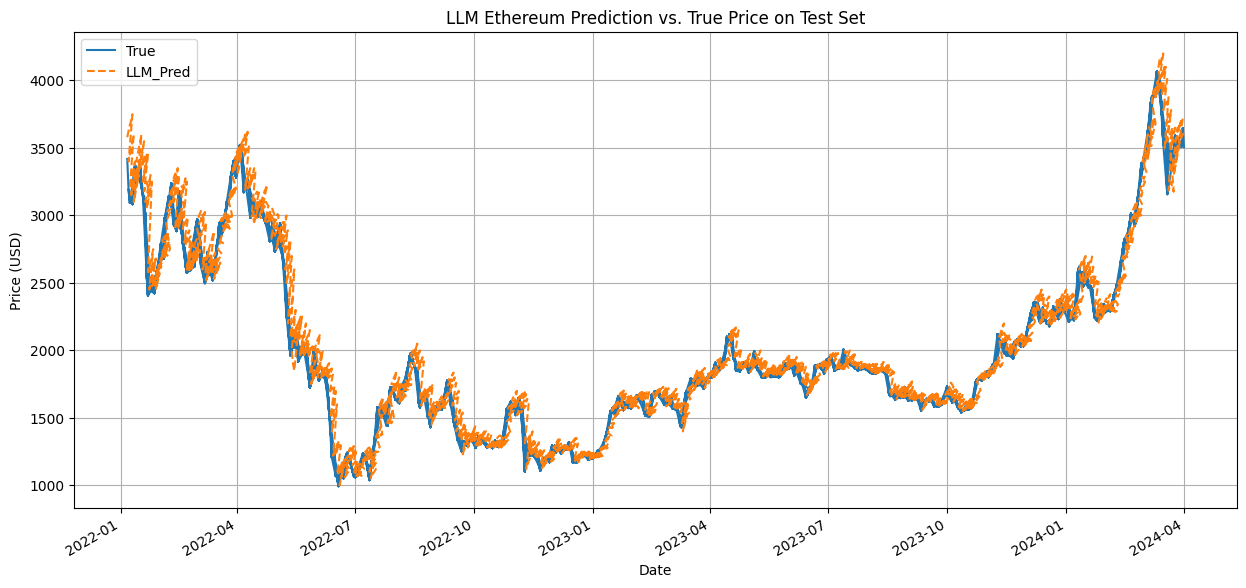

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
import re
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import userdata
import os

# 1. METHODOLOGY SETUP


# Clear proxies
os.environ['HTTP_PROXY'] = ''
os.environ['HTTPS_PROXY'] = ''
print("--- Proxy variables cleared ---")

# Basic parameters
N_STEPS = 60           # Context window
N_PRED_DAYS = 5        # Predict 5 days
TRAIN_SPLIT_PCT = 0.70 # Strict 70/30 split


# 2. DATA LOADING & ROBUST SPLITTING

try:
    # Loading the Ethereum file
    df_final = pd.read_csv("data_eth.csv", parse_dates=['Date'])
    df_final.set_index('Date', inplace=True)


    if not df_final.index.is_monotonic_increasing:
        print("Sorting data by date...")
        df_final.sort_index(inplace=True)
    print("Ethereum CSV file loaded successfully.")
except FileNotFoundError:
    print("ERROR: File 'data_eth.csv' not found. Please ensure it is in the correct directory.")
    df_final = pd.DataFrame()

if not df_final.empty:
    # Calculate CUTOFF_DATE based on the 70/30 split
    total_rows = len(df_final)
    split_index = int(total_rows * TRAIN_SPLIT_PCT)


    if split_index < N_STEPS:
        print(f"CRITICAL ERROR: Your 'train' split (70%) only contains {split_index} days.")
        df_final = pd.DataFrame()
    elif (total_rows - split_index) < N_PRED_DAYS:
         print(f"CRITICAL ERROR: Your 'test' split is too small for a {N_PRED_DAYS}-day forecast.")
         df_final = pd.DataFrame()
    else:
        CUTOFF_DATE = df_final.index[split_index]
        print("Data loaded and split successfully.")

if not df_final.empty:
    # Create the Evaluation Slice
    train_df = df_final[df_final.index < CUTOFF_DATE]
    test_start_index = split_index

    history_start_index = test_start_index - N_STEPS
    evaluation_df = df_final.iloc[history_start_index:]

    print(f"Test data runs from {evaluation_df.index.min().date()} to {evaluation_df.index.max().date()}")
    print(f"Cutoff Date (Train/Test Split): {CUTOFF_DATE.date()}")


# 3. LLM SETUP

try:
    api_key = userdata.get('BTCKEY')
    genai.configure(api_key=api_key)
    print("\nGoogle API Key configured successfully.")
    api_key_is_valid = True
except Exception as e:
    print(f"\nAPI Key configuration failed: {e}. The evaluation loop will be skipped.")
    api_key_is_valid = False

# 4. PROMPT ENGINEERING (H=5)
def serialize_data_for_llm(data_slice):
    """
    Converts a DataFrame slice into a richer text string for the LLM.
    """
    text_parts = []
    columns_to_include = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Pct_change', 'MA', 'EMA', 'OBV', 'MACD', 'Signal', 'PSAR', 'gold_close', 'EPU', 'GPRD'
    ]
    if not all(col in data_slice.columns for col in columns_to_include):
        missing_cols = [col for col in columns_to_include if col not in data_slice.columns]
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")

    for index in data_slice.index:
        row = data_slice.loc[index]
        daily_data = [f"J {index.strftime('%Y-%m-%d')}:"]
        for col in columns_to_include:
            if col == 'Volume':
                vol_in_mil = float(row[col]) / 1_000_000
                daily_data.append(f"V={vol_in_mil:.2f}M")
            else:
                daily_data.append(f"{col}={row[col]:.2f}")
        text_parts.append(" ".join(daily_data))
    return "; ".join(text_parts)

def create_llm_prompt(historical_data, start_date, end_date):
    """
    Creates a prompt for a 5-day Ethereum forecast.
    """
    one_shot_context = "J 2024-12-01: Open=3500.50 High=3600.00 Low=3480.25 Close=3550.75 V=4500.50M Pct_change=0.02 MA=3400.00 EMA=3450.00 OBV=1234567890.12 MACD=50.55 Signal=45.20 PSAR=3300.00 gold_close=2300.00 EPU=85.54 GPRD=165.62; ... etc. for 59 more days"
    one_shot_response = "3560.50, 3580.10, 3575.75, 3610.00, 3605.30"

    prompt = f"""You are a financial forecasting bot. Your task is to predict the closing price for Ethereum for the next {N_PRED_DAYS} days.
Respond with ONLY a comma-separated list of {N_PRED_DAYS} numerical values. Do not add any extra text.

### Example
Context: {one_shot_context}
Target Closing Prices: {one_shot_response}

### Prediction Task
Context: {serialize_data_for_llm(historical_data)}
Target Closing Prices for {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}:
"""
    return prompt

# 5. WALK-FORWARD EVALUATION LOOP

if api_key_is_valid and not df_final.empty:
    print(f"\n--- Starting Final Walk-Forward Evaluation for LLM ({N_PRED_DAYS}-Day Horizon) ---")

    llm_predictions = []

    # Calculate range based on available evaluation data
    test_range = range(len(evaluation_df) - N_STEPS - N_PRED_DAYS + 1)

    # Use flash model
    model_llm = genai.GenerativeModel('gemini-1.5-flash')

    for i in test_range:
        history_end_index = i + N_STEPS
        prediction_end_index = history_end_index + N_PRED_DAYS

        history_unscaled = evaluation_df.iloc[i:history_end_index]

        target_dates = evaluation_df.index[history_end_index:prediction_end_index]
        true_values = evaluation_df.iloc[history_end_index:prediction_end_index]['Close']

        # Create prompt
        prompt = create_llm_prompt(history_unscaled, target_dates[0], target_dates[-1])

        llm_preds_float = None
        max_retries = 3

        for attempt in range(max_retries):
            try:
                response = model_llm.generate_content(prompt)
                parsed_preds = re.findall(r'-?\d+\.?\d*', response.text)

                if len(parsed_preds) == N_PRED_DAYS:
                    llm_preds_float = [float(p) for p in parsed_preds]
                    break
                else:
                    raise ValueError(f"Expected {N_PRED_DAYS} predictions, but got {len(parsed_preds)}: '{response.text}'")

            except Exception as e:
                print(f"API call failed (Attempt {attempt + 1}/{max_retries}) for date {target_dates[0].date()}. Error: {e}")
                if attempt < max_retries - 1:
                    time.sleep(5)
                else:
                    print(f"Prediction failed after {max_retries} attempts for {target_dates[0].date()}.")

        if llm_preds_float:

            print(f"Prediction for {target_dates[0].date()} -> {target_dates[-1].date()}: Success")

            for j in range(N_PRED_DAYS):
                llm_predictions.append({
                    'Date': target_dates[j],
                    'True': true_values.iloc[j],
                    'LLM_Pred': llm_preds_float[j]
                })

        time.sleep(10) # Respect rate limits
else:
    print("\nThe evaluation loop is skipped due to an invalid API key or data loading failure.")


# 6. RESULTS ANALYSIS

if 'llm_predictions' in locals() and llm_predictions:
    results_df = pd.DataFrame(llm_predictions).set_index('Date')

    if not results_df.empty:
        y_true = results_df['True']
        y_pred = results_df['LLM_Pred']

        # Calculate Metrics
        rmse_llm = np.sqrt(mean_squared_error(y_true, y_pred))
        mae_llm = mean_absolute_error(y_true, y_pred)
        mape_llm = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2_llm = r2_score(y_true, y_pred)
        bias_llm = np.mean(y_pred - y_true)

        print("\n--- LLM Final Performance (Ethereum) ---")
        print(f"LLM RMSE (Root Mean Squared Error): {rmse_llm:.4f}")
        print(f"LLM MAE (Mean Absolute Error): {mae_llm:.4f}")
        print(f"LLM MAPE (Mean Absolute Percentage Error): {mape_llm:.2f}%")
        print(f"LLM R-squared (R²): {r2_llm:.4f}")
        print(f"LLM Bias (Mean Error): {bias_llm:.4f}")

        results_df[['True', 'LLM_Pred']].plot(figsize=(15, 7), title='LLM Ethereum Prediction vs. True Price on Test Set', style=['-', '--'])
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNo successful predictions were recorded to analyze.")
else:
    print("\nResults analysis skipped.")

Ethereum CSV file loaded successfully.
Data loaded and split successfully.
Test data runs from 2021-11-07 to 2024-04-01

Google API Key configured successfully.

--- Starting Final Walk-Forward Evaluation for LLM (15-Day Horizon) ---
Prediction for 2022-01-06 -> 2022-01-20: Success
Prediction for 2022-01-07 -> 2022-01-21: Success
Prediction for 2022-01-08 -> 2022-01-22: Success
Prediction for 2022-01-09 -> 2022-01-23: Success
Prediction for 2022-01-10 -> 2022-01-24: Success
Prediction for 2022-01-11 -> 2022-01-25: Success
Prediction for 2022-01-12 -> 2022-01-26: Success
Prediction for 2022-01-13 -> 2022-01-27: Success
Prediction for 2022-01-14 -> 2022-01-28: Success
Prediction for 2022-01-15 -> 2022-01-29: Success
Prediction for 2022-01-16 -> 2022-01-30: Success
Prediction for 2022-01-17 -> 2022-01-31: Success
Prediction for 2022-01-18 -> 2022-02-01: Success
Prediction for 2022-01-19 -> 2022-02-02: Success
Prediction for 2022-01-20 -> 2022-02-03: Success
Prediction for 2022-01-21 -> 20

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 659.48ms


Prediction for 2022-05-10 -> 2022-05-24: Success
Prediction for 2022-05-11 -> 2022-05-25: Success
Prediction for 2022-05-12 -> 2022-05-26: Success
Prediction for 2022-05-13 -> 2022-05-27: Success
Prediction for 2022-05-14 -> 2022-05-28: Success
Prediction for 2022-05-15 -> 2022-05-29: Success
Prediction for 2022-05-16 -> 2022-05-30: Success
Prediction for 2022-05-17 -> 2022-05-31: Success
Prediction for 2022-05-18 -> 2022-06-01: Success
Prediction for 2022-05-19 -> 2022-06-02: Success
Prediction for 2022-05-20 -> 2022-06-03: Success
Prediction for 2022-05-21 -> 2022-06-04: Success
Prediction for 2022-05-22 -> 2022-06-05: Success
Prediction for 2022-05-23 -> 2022-06-06: Success
Prediction for 2022-05-24 -> 2022-06-07: Success
Prediction for 2022-05-25 -> 2022-06-08: Success
Prediction for 2022-05-26 -> 2022-06-09: Success
Prediction for 2022-05-27 -> 2022-06-10: Success
Prediction for 2022-05-28 -> 2022-06-11: Success
Prediction for 2022-05-29 -> 2022-06-12: Success
Prediction for 2022-

ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 780.30ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 705.35ms
ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 680.16ms


Prediction for 2023-04-22 -> 2023-05-06: Success
Prediction for 2023-04-23 -> 2023-05-07: Success
Prediction for 2023-04-24 -> 2023-05-08: Success


ERROR:tornado.access:503 POST /v1beta/models/gemini-1.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 705.54ms


Prediction for 2023-04-25 -> 2023-05-09: Success
Prediction for 2023-04-26 -> 2023-05-10: Success
Prediction for 2023-04-27 -> 2023-05-11: Success
Prediction for 2023-04-28 -> 2023-05-12: Success
Prediction for 2023-04-29 -> 2023-05-13: Success
Prediction for 2023-04-30 -> 2023-05-14: Success
Prediction for 2023-05-01 -> 2023-05-15: Success
Prediction for 2023-05-02 -> 2023-05-16: Success
Prediction for 2023-05-03 -> 2023-05-17: Success
Prediction for 2023-05-04 -> 2023-05-18: Success
Prediction for 2023-05-05 -> 2023-05-19: Success
Prediction for 2023-05-06 -> 2023-05-20: Success
Prediction for 2023-05-07 -> 2023-05-21: Success
Prediction for 2023-05-08 -> 2023-05-22: Success
Prediction for 2023-05-09 -> 2023-05-23: Success
Prediction for 2023-05-10 -> 2023-05-24: Success
Prediction for 2023-05-11 -> 2023-05-25: Success
Prediction for 2023-05-12 -> 2023-05-26: Success
Prediction for 2023-05-13 -> 2023-05-27: Success
Prediction for 2023-05-14 -> 2023-05-28: Success
Prediction for 2023-

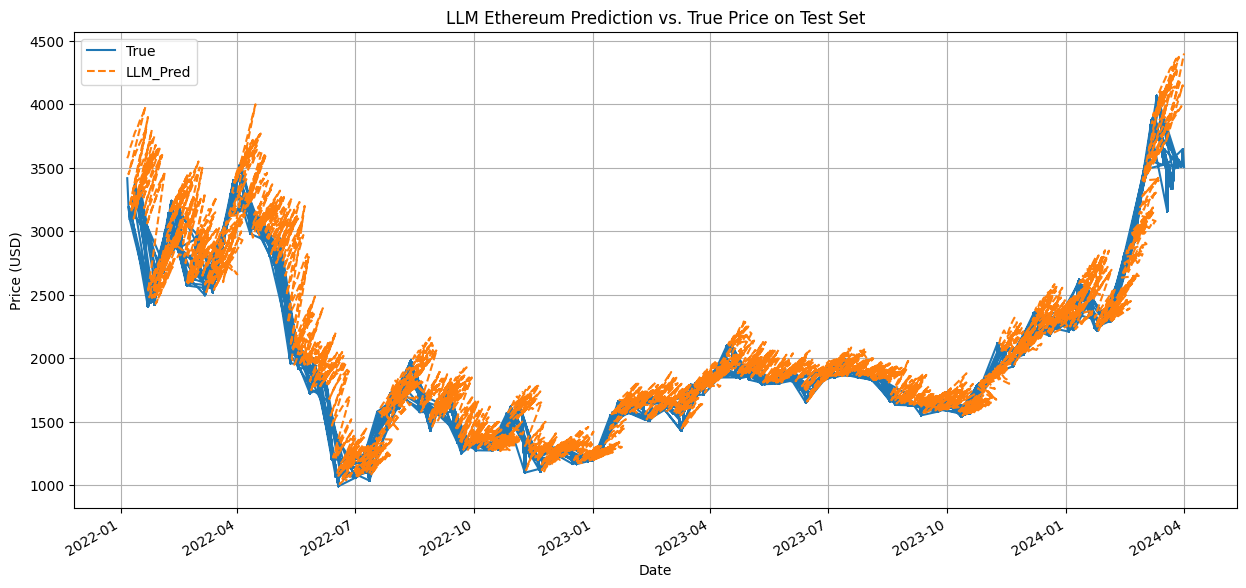

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
import re
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import userdata
import os


# 1. METHODOLOGY SETUP


# Clear proxies
os.environ['HTTP_PROXY'] = ''
os.environ['HTTPS_PROXY'] = ''
print("--- Proxy variables cleared ---")

# Basic parameters
N_STEPS = 60
N_PRED_DAYS = 15
TRAIN_SPLIT_PCT = 0.70

# 2. DATA LOADING

try:
    # Loading the Ethereum file
    df_final = pd.read_csv("data_eth.csv", parse_dates=['Date'])
    df_final.set_index('Date', inplace=True)


    if not df_final.index.is_monotonic_increasing:
        print("Sorting data by date...")
        df_final.sort_index(inplace=True)
    print("Ethereum CSV file loaded successfully.")
except FileNotFoundError:
    print("ERROR: File 'data_eth.csv' not found. Please ensure it is in the correct directory.")
    df_final = pd.DataFrame()

if not df_final.empty:
    # Calculate CUTOFF_DATE based on the 70/30 split
    total_rows = len(df_final)
    split_index = int(total_rows * TRAIN_SPLIT_PCT)

    if split_index < N_STEPS:
        print(f"CRITICAL ERROR: Your 'train' split (70%) only contains {split_index} days.")
        df_final = pd.DataFrame()
    elif (total_rows - split_index) < N_PRED_DAYS:
         print(f"CRITICAL ERROR: Your 'test' split is too small for a {N_PRED_DAYS}-day forecast.")
         df_final = pd.DataFrame()
    else:
        CUTOFF_DATE = df_final.index[split_index]
        print("Data loaded and split successfully.")

if not df_final.empty:
    # Create the Evaluation Slice
    train_df = df_final[df_final.index < CUTOFF_DATE]
    test_start_index = split_index


    history_start_index = test_start_index - N_STEPS
    evaluation_df = df_final.iloc[history_start_index:]


    print(f"Test data runs from {evaluation_df.index.min().date()} to {evaluation_df.index.max().date()}")


    print(f"Cutoff Date (Train/Test Split): {CUTOFF_DATE.date()}")


# 3. LLM SETUP

try:
    api_key = userdata.get('BTCKEY')
    genai.configure(api_key=api_key)
    print("\nGoogle API Key configured successfully.")
    api_key_is_valid = True
except Exception as e:
    print(f"\nAPI Key configuration failed: {e}. The evaluation loop will be skipped.")
    api_key_is_valid = False

# 4. PROMPT ENGINEERING

def serialize_data_for_llm(data_slice):
    """
    Converts a DataFrame slice into a richer text string for the LLM.
    """
    text_parts = []
    columns_to_include = [
        'Open', 'High', 'Low', 'Close', 'Volume', 'Pct_change', 'MA', 'EMA', 'OBV', 'MACD', 'Signal', 'PSAR', 'gold_close', 'EPU', 'GPRD'
    ]
    if not all(col in data_slice.columns for col in columns_to_include):
        missing_cols = [col for col in columns_to_include if col not in data_slice.columns]
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_cols}")

    for index in data_slice.index:
        row = data_slice.loc[index]
        daily_data = [f"J {index.strftime('%Y-%m-%d')}:"]
        for col in columns_to_include:
            if col == 'Volume':
                vol_in_mil = float(row[col]) / 1_000_000
                daily_data.append(f"V={vol_in_mil:.2f}M")
            else:
                daily_data.append(f"{col}={row[col]:.2f}")
        text_parts.append(" ".join(daily_data))
    return "; ".join(text_parts)

def create_llm_prompt(historical_data, start_date, end_date):
    """
    Creates a prompt for a 15-day Ethereum forecast.
    """
    one_shot_context = "J 2024-12-01: Open=3500.50 High=3600.00 Low=3480.25 Close=3550.75 V=4500.50M Pct_change=0.02 MA=3400.00 EMA=3450.00 OBV=1234567890.12 MACD=50.55 Signal=45.20 PSAR=3300.00 gold_close=2300.00 EPU=85.54 GPRD=165.62; ... etc. for 59 more days"
    one_shot_response = "3560.50, 3580.10, 3575.75, 3610.00, 3605.30, 3630.00, 3650.50, 3640.25, 3680.00, 3700.00, 3695.50, 3710.75, 3750.00, 3740.25, 3760.00"

    prompt = f"""You are a financial forecasting bot. Your task is to predict the closing price for Ethereum for the next {N_PRED_DAYS} days.
Respond with ONLY a comma-separated list of {N_PRED_DAYS} numerical values. Do not add any extra text.

### Example
Context: {one_shot_context}
Target Closing Prices: {one_shot_response}

### Prediction Task
Context: {serialize_data_for_llm(historical_data)}
Target Closing Prices for {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}:
"""
    return prompt

# 5. WALK-FORWARD EVALUATION LOOP


if api_key_is_valid and not df_final.empty:
    print(f"\n--- Starting Final Walk-Forward Evaluation for LLM ({N_PRED_DAYS}-Day Horizon) ---")

    llm_predictions = []

    # Calculate range based on available evaluation data
    test_range = range(len(evaluation_df) - N_STEPS - N_PRED_DAYS + 1)

    # Use flash model
    model_llm = genai.GenerativeModel('gemini-1.5-flash')

    for i in test_range:
        history_end_index = i + N_STEPS
        prediction_end_index = history_end_index + N_PRED_DAYS

        history_unscaled = evaluation_df.iloc[i:history_end_index]

        target_dates = evaluation_df.index[history_end_index:prediction_end_index]
        true_values = evaluation_df.iloc[history_end_index:prediction_end_index]['Close']

        # Create prompt
        prompt = create_llm_prompt(history_unscaled, target_dates[0], target_dates[-1])

        llm_preds_float = None
        max_retries = 3

        for attempt in range(max_retries):
            try:
                response = model_llm.generate_content(prompt)
                parsed_preds = re.findall(r'-?\d+\.?\d*', response.text)

                if len(parsed_preds) == N_PRED_DAYS:
                    llm_preds_float = [float(p) for p in parsed_preds]
                    break
                else:
                    raise ValueError(f"Expected {N_PRED_DAYS} predictions, but got {len(parsed_preds)}: '{response.text}'")

            except Exception as e:
                print(f"API call failed (Attempt {attempt + 1}/{max_retries}) for date {target_dates[0].date()}. Error: {e}")
                if attempt < max_retries - 1:
                    time.sleep(5)
                else:
                    print(f"Prediction failed after {max_retries} attempts for {target_dates[0].date()}.")

        if llm_preds_float:
            # Output
            print(f"Prediction for {target_dates[0].date()} -> {target_dates[-1].date()}: Success")

            for j in range(N_PRED_DAYS):
                llm_predictions.append({
                    'Date': target_dates[j],
                    'True': true_values.iloc[j],
                    'LLM_Pred': llm_preds_float[j]
                })

        time.sleep(10) # Respect rate limits
else:
    print("\nThe evaluation loop is skipped due to an invalid API key or data loading failure.")

# 6. RESULTS ANALYSIS

if 'llm_predictions' in locals() and llm_predictions:
    results_df = pd.DataFrame(llm_predictions).set_index('Date')

    if not results_df.empty:
        y_true = results_df['True']
        y_pred = results_df['LLM_Pred']

        # Calculate Metrics
        rmse_llm = np.sqrt(mean_squared_error(y_true, y_pred))
        mae_llm = mean_absolute_error(y_true, y_pred)
        mape_llm = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        r2_llm = r2_score(y_true, y_pred)
        bias_llm = np.mean(y_pred - y_true)

        print("\n--- LLM Final Performance (Ethereum) ---")
        print(f"LLM RMSE (Root Mean Squared Error): {rmse_llm:.4f}")
        print(f"LLM MAE (Mean Absolute Error): {mae_llm:.4f}")
        print(f"LLM MAPE (Mean Absolute Percentage Error): {mape_llm:.2f}%")
        print(f"LLM R-squared (R²): {r2_llm:.4f}")
        print(f"LLM Bias (Mean Error): {bias_llm:.4f}")

        results_df[['True', 'LLM_Pred']].plot(figsize=(15, 7), title='LLM Ethereum Prediction vs. True Price on Test Set', style=['-', '--'])
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNo successful predictions were recorded to analyze.")
else:
    print("\nResults analysis skipped.")